In [1]:
import scanpy as sc
adata=sc.read_h5ad("./data/GSE280883_cell_anova.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 91752 × 22831
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'replicate', 'compartment', 'source', 'day', 'batch', 'multiplet_state', 'ident'
    var: 'gene_id'
    uns: 'X_name'
    layers: 'logcounts'


In [2]:
import numpy as np
for i in adata.obs.columns:
    try:
        unique=np.unique(adata.obs[i])
        if len(unique)<100:
            print(i, unique)
    except:
        continue
print(adata.X[:10,:10])

orig.ident ['D10' 'D2' 'D20' 'D3.5']
seq_folder ['SeuratProject']
sample ['C' 'SR']
replicate [1. 2. 3. 4.]
compartment ['EPI' 'LP']
source ['CY' 'LL']
day [ 2.   3.5 10.  20. ]
batch ['10CCYEPI1' '10CCYLP1' '10SRCYEPI1' '10SRCYLP1' '10SRLLEPI1' '20CCYEPI1'
 '20CCYLP1' '20SRCYEPI1' '20SRCYLP1' '2CCYEPI1' '2CCYLP1' '2SRCYEPI1'
 '2SRCYLP1' '2SRCYLP2' '3.5CLLEPI1' '3.5CLLEPI2' '3.5SRLLEPI1'
 '3.5SRLLEPI2' '3.5SRLLEPI3' '3.5SRLLEPI4']


multiplet_state ['singlet']


ident ['D10' 'D2' 'D20' 'D3.5']
  (0, 5)	3.0
  (1, 5)	4.0
  (2, 5)	1.0
  (5, 5)	3.0
  (8, 5)	4.0
  (0, 6)	5.0
  (1, 6)	1.0
  (4, 6)	1.0
  (5, 6)	2.0
  (8, 6)	5.0
  (9, 6)	1.0
  (0, 7)	2.0
  (1, 7)	4.0
  (2, 7)	1.0
  (4, 7)	1.0
  (5, 7)	1.0
  (8, 7)	3.0
  (2, 9)	2.0
  (5, 9)	1.0


In [3]:
batch_real=[]
for i in range(adata.shape[0]):
    batch_real.append(str(adata.obs['orig.ident'][i])+"__"+str(adata.obs['source'][i])+"__"+str(adata.obs['replicate'][i]))
uniques=np.unique(np.array(batch_real))
print(uniques)

adata.obs["real_batch"]=np.array(batch_real)

adata.obs["replicate"]=np.array([str(i) for i in adata.obs["replicate"]])

adata.write_h5ad("./data/mouse.h5ad")

/tmp/ipykernel_1356326/2319539134.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_real.append(str(adata.obs['orig.ident'][i])+"__"+str(adata.obs['source'][i])+"__"+str(adata.obs['replicate'][i]))


['D10__CY__1.0' 'D10__LL__1.0' 'D20__CY__1.0' 'D2__CY__1.0' 'D2__CY__2.0'
 'D3.5__LL__1.0' 'D3.5__LL__2.0' 'D3.5__LL__3.0' 'D3.5__LL__4.0']


In [4]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


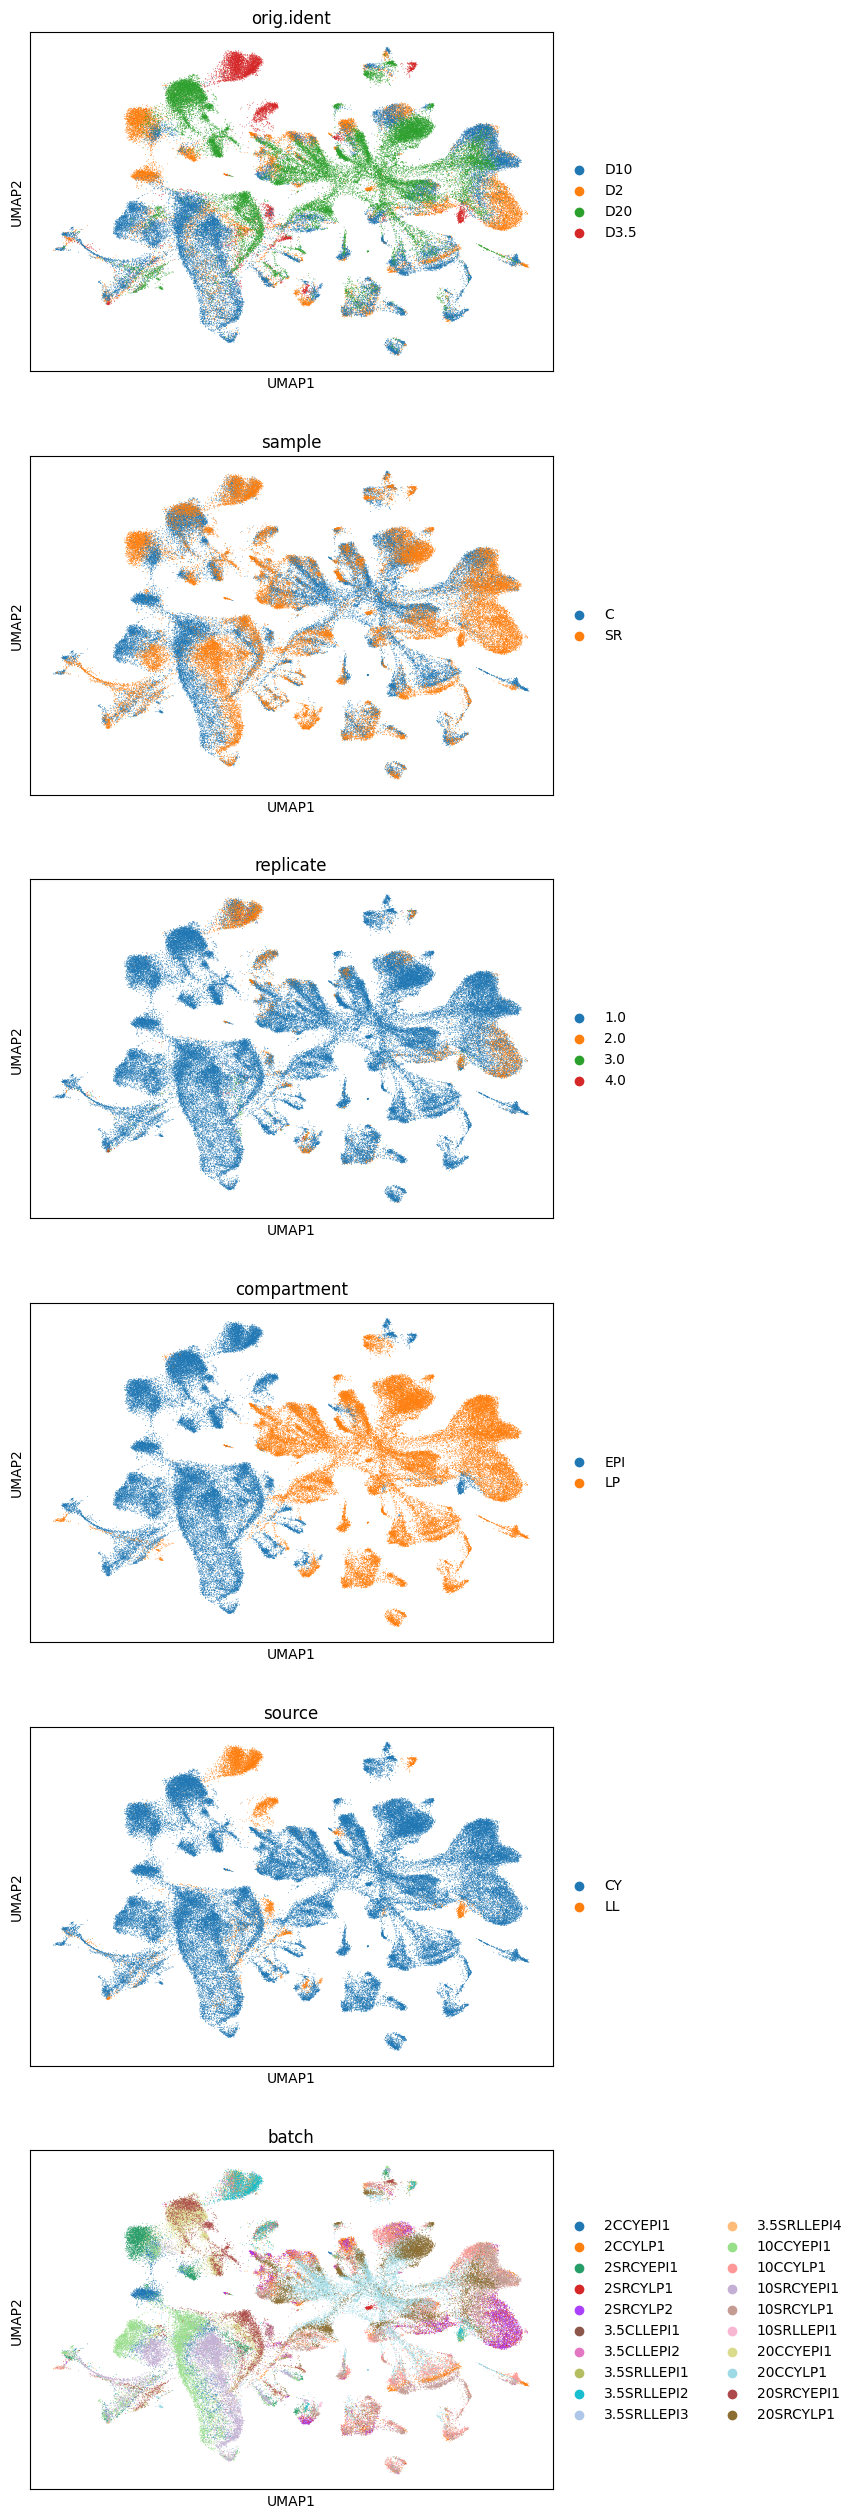

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["orig.ident","sample","replicate","compartment","source","batch"],ncols=1)

In [6]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="sample", contorl_name='C', num_hvg=2000, require_batch=True,
                            batch_key=['orig.ident',"replicate","source"],
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./mouse/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./mouse/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[orig.ident] back up to adata.obs['orig.ident_backup']
Original adata.obs[replicate] back up to adata.obs['replicate_backup']
Original adata.obs[source] back up to adata.obs['source_backup']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/data_preprocess.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_namei="--".join([str(adata.obs[batch_keyi][i]) for batch_keyi in batch_key])


Original adata.obs[sample] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'C': 0, 'SR': 1}
Condition mapping to adata.obs['batch']: {'orig.ident': {'D2': 0, 'D3.5': 1, 'D10': 2, 'D20': 3}, 'replicate': {'1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3}, 'source': {'CY': 0, 'LL': 1}}
Unique batch mapping: {'D2--1.0--CY': 0, 'D2--2.0--CY': 1, 'D3.5--1.0--LL': 2, 'D3.5--2.0--LL': 3, 'D3.5--3.0--LL': 4, 'D3.5--4.0--LL': 5, 'D10--1.0--CY': 6, 'D10--1.0--LL': 7, 'D20--1.0--CY': 8}


Calculating the clusters
Unique groups: ['0_C' '0_SR' '1_SR' '2_C' '2_SR' '3_C' '3_SR' '4_SR' '5_SR' '6_C' '6_SR'
 '7_SR' '8_C' '8_SR']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:38: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  clustering_function(adata, resolution=resolution1)


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Finished clustering
Data preprocessing done


Remaining number of cells: 91288
Too few epoches (steps, if rigorously speaking). Changing epoch to 96 to adjust for number of cells
Require batch: True
Batch name to number mapping (may be used for search for saved adata):
 {'orig.ident': {'D2': 0, 'D3.5': 1, 'D10': 2, 'D20': 3}, 'replicate': {'1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3}, 'source': {'CY': 0, 'LL': 1}}
Condition name to number mapping (may be used for search for saved adata):
 {'C': 0, 'SR': 1}
Preprocessing time: 82.29593 seconds


Overall Progress:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch: 1/96 | All Loss: 219.1403 | Neighborhood Loss: 75.3712 | Triplet Loss: 11.1721 | Reconstruction Loss: 10.4688 | Independent Loss: 135.7430 | KL Loss: 0.4456 | Commitment Loss: 0.5604 | Dependent Loss: -14.6208


Epoch: 2/96 | All Loss: 178.5113 | Neighborhood Loss: 76.4496 | Triplet Loss: 5.9724 | Reconstruction Loss: 7.4206 | Independent Loss: 98.9899 | KL Loss: 0.3283 | Commitment Loss: 0.5418 | Dependent Loss: -11.1913


Resetting 766 unused embeddings.
Resetting 752 unused embeddings.
Resetting 757 unused embeddings.
Resetting 734 unused embeddings.


Resetting 744 unused embeddings.
Resetting 732 unused embeddings.
Resetting 756 unused embeddings.
Resetting 746 unused embeddings.


Resetting 760 unused embeddings.
Resetting 736 unused embeddings.
Resetting 725 unused embeddings.
Resetting 744 unused embeddings.


Resetting 773 unused embeddings.
Resetting 748 unused embeddings.
Resetting 727 unused embeddings.
Resetting 782 unused embeddings.


Resetting 761 unused embeddings.
Resetting 756 unused embeddings.
Resetting 759 unused embeddings.
Resetting 756 unused embeddings.


Resetting 772 unused embeddings.
Resetting 731 unused embeddings.
Resetting 788 unused embeddings.
Resetting 760 unused embeddings.


Resetting 757 unused embeddings.
Resetting 769 unused embeddings.
Resetting 740 unused embeddings.
Resetting 725 unused embeddings.


Resetting 774 unused embeddings.
Resetting 757 unused embeddings.
Resetting 730 unused embeddings.
Resetting 753 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Epoch: 3/96 | All Loss: 137.5132 | Neighborhood Loss: 72.9222 | Triplet Loss: 6.4549 | Reconstruction Loss: 6.1327 | Independent Loss: 58.1886 | KL Loss: 0.1910 | Commitment Loss: 0.1990 | Dependent Loss: -6.5753


Epoch: 4/96 | All Loss: 131.3078 | Neighborhood Loss: 76.2335 | Triplet Loss: 5.4372 | Reconstruction Loss: 6.2565 | Independent Loss: 49.0479 | KL Loss: 0.1628 | Commitment Loss: 0.1910 | Dependent Loss: -6.0211


Resetting 691 unused embeddings.
Resetting 678 unused embeddings.
Resetting 617 unused embeddings.
Resetting 623 unused embeddings.


Resetting 640 unused embeddings.
Resetting 636 unused embeddings.
Resetting 651 unused embeddings.
Resetting 661 unused embeddings.


Resetting 648 unused embeddings.
Resetting 652 unused embeddings.
Resetting 708 unused embeddings.
Resetting 654 unused embeddings.


Resetting 699 unused embeddings.
Resetting 756 unused embeddings.
Resetting 634 unused embeddings.
Resetting 658 unused embeddings.


Resetting 654 unused embeddings.
Resetting 704 unused embeddings.
Resetting 702 unused embeddings.
Resetting 627 unused embeddings.


Resetting 652 unused embeddings.
Resetting 721 unused embeddings.
Resetting 673 unused embeddings.
Resetting 702 unused embeddings.


Resetting 642 unused embeddings.
Resetting 718 unused embeddings.
Resetting 728 unused embeddings.
Resetting 608 unused embeddings.


Resetting 634 unused embeddings.
Resetting 646 unused embeddings.
Resetting 620 unused embeddings.
Resetting 754 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4


Epoch: 5/96 | All Loss: 116.3090 | Neighborhood Loss: 70.1748 | Triplet Loss: 4.4030 | Reconstruction Loss: 5.6685 | Independent Loss: 40.9754 | KL Loss: 0.1384 | Commitment Loss: 0.1539 | Dependent Loss: -5.2051


Epoch: 6/96 | All Loss: 116.6066 | Neighborhood Loss: 70.8324 | Triplet Loss: 4.0768 | Reconstruction Loss: 5.8381 | Independent Loss: 40.9640 | KL Loss: 0.1486 | Commitment Loss: 0.1625 | Dependent Loss: -5.4159


Resetting 672 unused embeddings.
Resetting 666 unused embeddings.
Resetting 644 unused embeddings.
Resetting 583 unused embeddings.


Resetting 602 unused embeddings.
Resetting 643 unused embeddings.
Resetting 641 unused embeddings.
Resetting 678 unused embeddings.


Resetting 637 unused embeddings.
Resetting 663 unused embeddings.
Resetting 695 unused embeddings.
Resetting 638 unused embeddings.


Resetting 685 unused embeddings.
Resetting 671 unused embeddings.
Resetting 626 unused embeddings.
Resetting 648 unused embeddings.


Resetting 646 unused embeddings.
Resetting 661 unused embeddings.
Resetting 688 unused embeddings.
Resetting 631 unused embeddings.


Resetting 672 unused embeddings.
Resetting 662 unused embeddings.
Resetting 666 unused embeddings.
Resetting 671 unused embeddings.


Resetting 653 unused embeddings.
Resetting 658 unused embeddings.
Resetting 711 unused embeddings.
Resetting 624 unused embeddings.


Resetting 655 unused embeddings.
Resetting 631 unused embeddings.
Resetting 649 unused embeddings.
Resetting 705 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Epoch: 7/96 | All Loss: 106.1640 | Neighborhood Loss: 65.9158 | Triplet Loss: 3.4945 | Reconstruction Loss: 5.3189 | Independent Loss: 36.0835 | KL Loss: 0.1338 | Commitment Loss: 0.1521 | Dependent Loss: -4.9346


Epoch: 8/96 | All Loss: 113.3721 | Neighborhood Loss: 69.5195 | Triplet Loss: 3.5542 | Reconstruction Loss: 5.7167 | Independent Loss: 39.9865 | KL Loss: 0.1452 | Commitment Loss: 0.1712 | Dependent Loss: -5.7212


Resetting 681 unused embeddings.
Resetting 660 unused embeddings.
Resetting 652 unused embeddings.
Resetting 610 unused embeddings.


Resetting 624 unused embeddings.
Resetting 654 unused embeddings.
Resetting 650 unused embeddings.
Resetting 674 unused embeddings.


Resetting 644 unused embeddings.
Resetting 669 unused embeddings.
Resetting 682 unused embeddings.
Resetting 651 unused embeddings.


Resetting 688 unused embeddings.
Resetting 651 unused embeddings.
Resetting 625 unused embeddings.
Resetting 658 unused embeddings.


Resetting 654 unused embeddings.
Resetting 658 unused embeddings.
Resetting 695 unused embeddings.
Resetting 643 unused embeddings.


Resetting 673 unused embeddings.
Resetting 662 unused embeddings.
Resetting 662 unused embeddings.
Resetting 650 unused embeddings.


Resetting 650 unused embeddings.
Resetting 675 unused embeddings.
Resetting 705 unused embeddings.
Resetting 633 unused embeddings.


Resetting 662 unused embeddings.
Resetting 643 unused embeddings.
Resetting 656 unused embeddings.
Resetting 702 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Epoch: 9/96 | All Loss: 101.5043 | Neighborhood Loss: 62.2527 | Triplet Loss: 3.1279 | Reconstruction Loss: 5.1891 | Independent Loss: 36.1726 | KL Loss: 0.1344 | Commitment Loss: 0.1601 | Dependent Loss: -5.5326


Epoch: 10/96 | All Loss: 107.3984 | Neighborhood Loss: 66.6075 | Triplet Loss: 3.1989 | Reconstruction Loss: 5.5813 | Independent Loss: 37.4415 | KL Loss: 0.1381 | Commitment Loss: 0.1645 | Dependent Loss: -5.7335


Resetting 689 unused embeddings.
Resetting 673 unused embeddings.
Resetting 662 unused embeddings.
Resetting 625 unused embeddings.


Resetting 645 unused embeddings.
Resetting 662 unused embeddings.
Resetting 663 unused embeddings.
Resetting 674 unused embeddings.


Resetting 653 unused embeddings.
Resetting 677 unused embeddings.
Resetting 701 unused embeddings.
Resetting 666 unused embeddings.


Resetting 702 unused embeddings.
Resetting 671 unused embeddings.
Resetting 633 unused embeddings.
Resetting 664 unused embeddings.


Resetting 669 unused embeddings.
Resetting 684 unused embeddings.
Resetting 693 unused embeddings.
Resetting 650 unused embeddings.


Resetting 677 unused embeddings.
Resetting 665 unused embeddings.
Resetting 675 unused embeddings.
Resetting 653 unused embeddings.


Resetting 660 unused embeddings.
Resetting 685 unused embeddings.
Resetting 706 unused embeddings.
Resetting 653 unused embeddings.


Resetting 676 unused embeddings.
Resetting 655 unused embeddings.
Resetting 667 unused embeddings.
Resetting 683 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 10


Epoch: 11/96 | All Loss: 96.8075 | Neighborhood Loss: 61.1227 | Triplet Loss: 2.9981 | Reconstruction Loss: 5.0948 | Independent Loss: 32.6892 | KL Loss: 0.1311 | Commitment Loss: 0.1530 | Dependent Loss: -5.3814


Epoch: 12/96 | All Loss: 104.0150 | Neighborhood Loss: 64.5374 | Triplet Loss: 2.8548 | Reconstruction Loss: 5.5194 | Independent Loss: 37.0660 | KL Loss: 0.1464 | Commitment Loss: 0.1716 | Dependent Loss: -6.2805


Resetting 688 unused embeddings.
Resetting 676 unused embeddings.
Resetting 670 unused embeddings.
Resetting 642 unused embeddings.


Resetting 661 unused embeddings.
Resetting 668 unused embeddings.
Resetting 673 unused embeddings.
Resetting 677 unused embeddings.


Resetting 669 unused embeddings.
Resetting 680 unused embeddings.
Resetting 714 unused embeddings.
Resetting 668 unused embeddings.


Resetting 707 unused embeddings.
Resetting 691 unused embeddings.
Resetting 641 unused embeddings.
Resetting 668 unused embeddings.


Resetting 686 unused embeddings.
Resetting 700 unused embeddings.
Resetting 704 unused embeddings.
Resetting 658 unused embeddings.


Resetting 688 unused embeddings.
Resetting 671 unused embeddings.
Resetting 687 unused embeddings.
Resetting 674 unused embeddings.


Resetting 669 unused embeddings.
Resetting 691 unused embeddings.
Resetting 711 unused embeddings.
Resetting 665 unused embeddings.


Resetting 689 unused embeddings.
Resetting 661 unused embeddings.
Resetting 682 unused embeddings.
Resetting 689 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 12


Epoch: 13/96 | All Loss: 93.6376 | Neighborhood Loss: 59.4976 | Triplet Loss: 2.5796 | Reconstruction Loss: 5.0432 | Independent Loss: 32.2533 | KL Loss: 0.1380 | Commitment Loss: 0.1609 | Dependent Loss: -6.0349


Epoch: 14/96 | All Loss: 102.0568 | Neighborhood Loss: 64.4998 | Triplet Loss: 2.7644 | Reconstruction Loss: 5.4357 | Independent Loss: 35.7623 | KL Loss: 0.1387 | Commitment Loss: 0.1748 | Dependent Loss: -6.7189


Resetting 694 unused embeddings.
Resetting 681 unused embeddings.
Resetting 673 unused embeddings.
Resetting 657 unused embeddings.


Resetting 669 unused embeddings.
Resetting 675 unused embeddings.
Resetting 676 unused embeddings.
Resetting 685 unused embeddings.


Resetting 679 unused embeddings.
Resetting 677 unused embeddings.
Resetting 718 unused embeddings.
Resetting 674 unused embeddings.


Resetting 712 unused embeddings.
Resetting 710 unused embeddings.
Resetting 647 unused embeddings.
Resetting 672 unused embeddings.


Resetting 692 unused embeddings.
Resetting 710 unused embeddings.
Resetting 705 unused embeddings.
Resetting 663 unused embeddings.


Resetting 688 unused embeddings.
Resetting 689 unused embeddings.
Resetting 693 unused embeddings.
Resetting 687 unused embeddings.


Resetting 674 unused embeddings.
Resetting 695 unused embeddings.
Resetting 721 unused embeddings.
Resetting 668 unused embeddings.


Resetting 690 unused embeddings.
Resetting 667 unused embeddings.
Resetting 685 unused embeddings.
Resetting 687 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/96 | All Loss: 92.6073 | Neighborhood Loss: 58.8889 | Triplet Loss: 2.2030 | Reconstruction Loss: 5.0694 | Independent Loss: 32.5502 | KL Loss: 0.1270 | Commitment Loss: 0.1639 | Dependent Loss: -6.3951


Epoch: 16/96 | All Loss: 98.8192 | Neighborhood Loss: 62.4417 | Triplet Loss: 2.0746 | Reconstruction Loss: 5.3781 | Independent Loss: 35.8780 | KL Loss: 0.1575 | Commitment Loss: 0.1824 | Dependent Loss: -7.2932


Epoch: 17/96 | All Loss: 96.3999 | Neighborhood Loss: 63.4345 | Triplet Loss: 2.1355 | Reconstruction Loss: 5.3987 | Independent Loss: 32.3521 | KL Loss: 0.1478 | Commitment Loss: 0.1837 | Dependent Loss: -7.2523


Resetting 700 unused embeddings.
Resetting 691 unused embeddings.
Resetting 676 unused embeddings.
Resetting 664 unused embeddings.


Resetting 671 unused embeddings.
Resetting 681 unused embeddings.
Resetting 680 unused embeddings.
Resetting 695 unused embeddings.


Resetting 687 unused embeddings.
Resetting 682 unused embeddings.
Resetting 724 unused embeddings.
Resetting 684 unused embeddings.


Resetting 715 unused embeddings.
Resetting 716 unused embeddings.
Resetting 651 unused embeddings.
Resetting 676 unused embeddings.


Resetting 702 unused embeddings.
Resetting 720 unused embeddings.
Resetting 715 unused embeddings.
Resetting 674 unused embeddings.


Resetting 694 unused embeddings.
Resetting 701 unused embeddings.
Resetting 697 unused embeddings.
Resetting 697 unused embeddings.


Resetting 679 unused embeddings.
Resetting 701 unused embeddings.
Resetting 727 unused embeddings.
Resetting 670 unused embeddings.


Resetting 695 unused embeddings.
Resetting 670 unused embeddings.
Resetting 690 unused embeddings.
Resetting 698 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 17


Epoch: 18/96 | All Loss: 88.9664 | Neighborhood Loss: 58.3844 | Triplet Loss: 2.3753 | Reconstruction Loss: 5.0941 | Independent Loss: 29.3232 | KL Loss: 0.1358 | Commitment Loss: 0.1679 | Dependent Loss: -6.5143


Epoch: 19/96 | All Loss: 96.2516 | Neighborhood Loss: 64.7484 | Triplet Loss: 2.4257 | Reconstruction Loss: 5.4284 | Independent Loss: 30.7780 | KL Loss: 0.1578 | Commitment Loss: 0.1859 | Dependent Loss: -7.4725


Resetting 707 unused embeddings.
Resetting 696 unused embeddings.
Resetting 679 unused embeddings.
Resetting 673 unused embeddings.


Resetting 671 unused embeddings.
Resetting 684 unused embeddings.
Resetting 680 unused embeddings.
Resetting 699 unused embeddings.


Resetting 687 unused embeddings.
Resetting 686 unused embeddings.
Resetting 734 unused embeddings.
Resetting 692 unused embeddings.


Resetting 719 unused embeddings.
Resetting 722 unused embeddings.
Resetting 658 unused embeddings.
Resetting 681 unused embeddings.


Resetting 709 unused embeddings.
Resetting 728 unused embeddings.
Resetting 724 unused embeddings.
Resetting 679 unused embeddings.


Resetting 699 unused embeddings.
Resetting 711 unused embeddings.
Resetting 694 unused embeddings.
Resetting 701 unused embeddings.


Resetting 680 unused embeddings.
Resetting 708 unused embeddings.
Resetting 732 unused embeddings.
Resetting 672 unused embeddings.


Resetting 695 unused embeddings.
Resetting 670 unused embeddings.
Resetting 691 unused embeddings.
Resetting 698 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 19


Epoch: 20/96 | All Loss: 92.3159 | Neighborhood Loss: 58.4297 | Triplet Loss: 2.0296 | Reconstruction Loss: 4.9519 | Independent Loss: 34.0431 | KL Loss: 0.1400 | Commitment Loss: 0.1777 | Dependent Loss: -7.4562


Epoch: 21/96 | All Loss: 96.3443 | Neighborhood Loss: 63.2804 | Triplet Loss: 1.8898 | Reconstruction Loss: 5.4142 | Independent Loss: 33.1857 | KL Loss: 0.1478 | Commitment Loss: 0.1906 | Dependent Loss: -7.7641


Resetting 713 unused embeddings.
Resetting 698 unused embeddings.
Resetting 681 unused embeddings.
Resetting 676 unused embeddings.


Resetting 671 unused embeddings.
Resetting 690 unused embeddings.
Resetting 683 unused embeddings.
Resetting 701 unused embeddings.


Resetting 688 unused embeddings.
Resetting 687 unused embeddings.
Resetting 734 unused embeddings.
Resetting 692 unused embeddings.


Resetting 722 unused embeddings.
Resetting 729 unused embeddings.
Resetting 668 unused embeddings.
Resetting 683 unused embeddings.


Resetting 713 unused embeddings.
Resetting 733 unused embeddings.
Resetting 728 unused embeddings.
Resetting 683 unused embeddings.


Resetting 702 unused embeddings.
Resetting 717 unused embeddings.
Resetting 697 unused embeddings.
Resetting 708 unused embeddings.


Resetting 682 unused embeddings.
Resetting 707 unused embeddings.
Resetting 737 unused embeddings.
Resetting 675 unused embeddings.


Resetting 703 unused embeddings.
Resetting 675 unused embeddings.
Resetting 696 unused embeddings.
Resetting 706 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 21


Epoch: 22/96 | All Loss: 87.2740 | Neighborhood Loss: 57.6501 | Triplet Loss: 1.8377 | Reconstruction Loss: 4.9459 | Independent Loss: 29.8068 | KL Loss: 0.1504 | Commitment Loss: 0.1818 | Dependent Loss: -7.2987


Epoch: 23/96 | All Loss: 91.7895 | Neighborhood Loss: 60.6405 | Triplet Loss: 2.1016 | Reconstruction Loss: 5.3004 | Independent Loss: 31.4295 | KL Loss: 0.1596 | Commitment Loss: 0.1992 | Dependent Loss: -8.0414


Resetting 716 unused embeddings.
Resetting 707 unused embeddings.
Resetting 684 unused embeddings.
Resetting 683 unused embeddings.


Resetting 671 unused embeddings.
Resetting 691 unused embeddings.
Resetting 686 unused embeddings.
Resetting 705 unused embeddings.


Resetting 691 unused embeddings.
Resetting 692 unused embeddings.
Resetting 737 unused embeddings.
Resetting 695 unused embeddings.


Resetting 722 unused embeddings.
Resetting 732 unused embeddings.
Resetting 669 unused embeddings.
Resetting 686 unused embeddings.


Resetting 718 unused embeddings.
Resetting 734 unused embeddings.
Resetting 734 unused embeddings.
Resetting 686 unused embeddings.


Resetting 708 unused embeddings.
Resetting 728 unused embeddings.
Resetting 700 unused embeddings.
Resetting 714 unused embeddings.


Resetting 688 unused embeddings.
Resetting 715 unused embeddings.
Resetting 741 unused embeddings.
Resetting 676 unused embeddings.


Resetting 708 unused embeddings.
Resetting 683 unused embeddings.
Resetting 699 unused embeddings.
Resetting 711 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 23


Epoch: 24/96 | All Loss: 83.4173 | Neighborhood Loss: 56.7450 | Triplet Loss: 1.8755 | Reconstruction Loss: 4.9061 | Independent Loss: 27.2889 | KL Loss: 0.1456 | Commitment Loss: 0.1886 | Dependent Loss: -7.7323


Epoch: 25/96 | All Loss: 91.1154 | Neighborhood Loss: 62.6379 | Triplet Loss: 1.9271 | Reconstruction Loss: 5.2596 | Independent Loss: 29.5838 | KL Loss: 0.1640 | Commitment Loss: 0.2055 | Dependent Loss: -8.6624


Resetting 717 unused embeddings.
Resetting 711 unused embeddings.
Resetting 685 unused embeddings.
Resetting 685 unused embeddings.


Resetting 673 unused embeddings.
Resetting 695 unused embeddings.
Resetting 688 unused embeddings.
Resetting 712 unused embeddings.


Resetting 697 unused embeddings.
Resetting 696 unused embeddings.
Resetting 737 unused embeddings.
Resetting 699 unused embeddings.


Resetting 725 unused embeddings.
Resetting 735 unused embeddings.
Resetting 673 unused embeddings.
Resetting 689 unused embeddings.


Resetting 724 unused embeddings.
Resetting 737 unused embeddings.
Resetting 738 unused embeddings.
Resetting 692 unused embeddings.


Resetting 710 unused embeddings.
Resetting 736 unused embeddings.
Resetting 702 unused embeddings.
Resetting 715 unused embeddings.


Resetting 693 unused embeddings.
Resetting 718 unused embeddings.
Resetting 739 unused embeddings.
Resetting 678 unused embeddings.


Resetting 709 unused embeddings.
Resetting 688 unused embeddings.
Resetting 705 unused embeddings.
Resetting 718 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 25


Epoch: 26/96 | All Loss: 81.9968 | Neighborhood Loss: 56.0711 | Triplet Loss: 2.0740 | Reconstruction Loss: 4.8647 | Independent Loss: 26.8832 | KL Loss: 0.1418 | Commitment Loss: 0.1935 | Dependent Loss: -8.2316


Epoch: 27/96 | All Loss: 87.2791 | Neighborhood Loss: 60.6372 | Triplet Loss: 1.9352 | Reconstruction Loss: 5.2278 | Independent Loss: 28.3421 | KL Loss: 0.1565 | Commitment Loss: 0.2119 | Dependent Loss: -9.2316


Resetting 720 unused embeddings.
Resetting 715 unused embeddings.
Resetting 689 unused embeddings.
Resetting 689 unused embeddings.


Resetting 675 unused embeddings.
Resetting 696 unused embeddings.
Resetting 689 unused embeddings.
Resetting 714 unused embeddings.


Resetting 694 unused embeddings.
Resetting 701 unused embeddings.
Resetting 741 unused embeddings.
Resetting 702 unused embeddings.


Resetting 726 unused embeddings.
Resetting 735 unused embeddings.
Resetting 675 unused embeddings.
Resetting 691 unused embeddings.


Resetting 733 unused embeddings.
Resetting 738 unused embeddings.
Resetting 737 unused embeddings.
Resetting 694 unused embeddings.


Resetting 715 unused embeddings.
Resetting 742 unused embeddings.
Resetting 708 unused embeddings.
Resetting 717 unused embeddings.


Resetting 697 unused embeddings.
Resetting 727 unused embeddings.
Resetting 748 unused embeddings.
Resetting 681 unused embeddings.


Resetting 712 unused embeddings.
Resetting 693 unused embeddings.
Resetting 704 unused embeddings.
Resetting 727 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 27


Epoch: 28/96 | All Loss: 82.4732 | Neighborhood Loss: 58.9310 | Triplet Loss: 1.8317 | Reconstruction Loss: 4.8285 | Independent Loss: 24.7930 | KL Loss: 0.1515 | Commitment Loss: 0.1970 | Dependent Loss: -8.2595


Epoch: 29/96 | All Loss: 87.6016 | Neighborhood Loss: 61.6308 | Triplet Loss: 2.1637 | Reconstruction Loss: 5.3743 | Independent Loss: 27.0136 | KL Loss: 0.1590 | Commitment Loss: 0.2194 | Dependent Loss: -8.9592


Resetting 723 unused embeddings.
Resetting 721 unused embeddings.
Resetting 692 unused embeddings.
Resetting 695 unused embeddings.


Resetting 678 unused embeddings.
Resetting 700 unused embeddings.
Resetting 683 unused embeddings.
Resetting 716 unused embeddings.


Resetting 696 unused embeddings.
Resetting 701 unused embeddings.
Resetting 745 unused embeddings.
Resetting 706 unused embeddings.


Resetting 731 unused embeddings.
Resetting 738 unused embeddings.
Resetting 679 unused embeddings.
Resetting 693 unused embeddings.


Resetting 736 unused embeddings.
Resetting 739 unused embeddings.
Resetting 737 unused embeddings.
Resetting 694 unused embeddings.


Resetting 716 unused embeddings.
Resetting 743 unused embeddings.
Resetting 711 unused embeddings.
Resetting 719 unused embeddings.


Resetting 698 unused embeddings.
Resetting 730 unused embeddings.
Resetting 753 unused embeddings.
Resetting 684 unused embeddings.


Resetting 716 unused embeddings.
Resetting 698 unused embeddings.
Resetting 705 unused embeddings.
Resetting 732 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 29
Epoch: 30/96 | All Loss: 81.7060 | Neighborhood Loss: 58.5928 | Triplet Loss: 2.3201 | Reconstruction Loss: 5.0444 | Independent Loss: 23.3621 | KL Loss: 0.1555 | Commitment Loss: 0.1991 | Dependent Loss: -7.9681


Epoch: 31/96 | All Loss: 85.7124 | Neighborhood Loss: 62.5994 | Triplet Loss: 2.1208 | Reconstruction Loss: 5.2842 | Independent Loss: 24.0930 | KL Loss: 0.1644 | Commitment Loss: 0.2169 | Dependent Loss: -8.7663


Epoch: 32/96 | All Loss: 81.8084 | Neighborhood Loss: 59.0883 | Triplet Loss: 2.0301 | Reconstruction Loss: 5.0548 | Independent Loss: 24.2050 | KL Loss: 0.1663 | Commitment Loss: 0.2185 | Dependent Loss: -8.9546


Resetting 726 unused embeddings.
Resetting 724 unused embeddings.
Resetting 694 unused embeddings.
Resetting 698 unused embeddings.


Resetting 684 unused embeddings.
Resetting 705 unused embeddings.
Resetting 686 unused embeddings.
Resetting 718 unused embeddings.


Resetting 702 unused embeddings.
Resetting 704 unused embeddings.
Resetting 745 unused embeddings.
Resetting 709 unused embeddings.


Resetting 733 unused embeddings.
Resetting 742 unused embeddings.
Resetting 682 unused embeddings.
Resetting 700 unused embeddings.


Resetting 739 unused embeddings.
Resetting 741 unused embeddings.
Resetting 739 unused embeddings.
Resetting 695 unused embeddings.


Resetting 719 unused embeddings.
Resetting 748 unused embeddings.
Resetting 709 unused embeddings.
Resetting 727 unused embeddings.


Resetting 700 unused embeddings.
Resetting 732 unused embeddings.
Resetting 760 unused embeddings.
Resetting 686 unused embeddings.


Resetting 717 unused embeddings.
Resetting 700 unused embeddings.
Resetting 706 unused embeddings.
Resetting 734 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 32


Epoch: 33/96 | All Loss: 74.2516 | Neighborhood Loss: 53.6833 | Triplet Loss: 1.7766 | Reconstruction Loss: 4.6463 | Independent Loss: 22.3571 | KL Loss: 0.1525 | Commitment Loss: 0.2097 | Dependent Loss: -8.5740


Epoch: 34/96 | All Loss: 83.0855 | Neighborhood Loss: 59.8026 | Triplet Loss: 1.9644 | Reconstruction Loss: 5.0751 | Independent Loss: 24.9510 | KL Loss: 0.1642 | Commitment Loss: 0.2230 | Dependent Loss: -9.0948


Resetting 728 unused embeddings.
Resetting 730 unused embeddings.
Resetting 698 unused embeddings.
Resetting 701 unused embeddings.


Resetting 684 unused embeddings.
Resetting 710 unused embeddings.
Resetting 686 unused embeddings.
Resetting 721 unused embeddings.


Resetting 706 unused embeddings.
Resetting 706 unused embeddings.
Resetting 752 unused embeddings.
Resetting 713 unused embeddings.


Resetting 738 unused embeddings.
Resetting 744 unused embeddings.
Resetting 684 unused embeddings.
Resetting 701 unused embeddings.


Resetting 742 unused embeddings.
Resetting 742 unused embeddings.
Resetting 739 unused embeddings.


Resetting 695 unused embeddings.
Resetting 727 unused embeddings.
Resetting 752 unused embeddings.
Resetting 708 unused embeddings.


Resetting 732 unused embeddings.
Resetting 701 unused embeddings.
Resetting 737 unused embeddings.
Resetting 769 unused embeddings.


Resetting 689 unused embeddings.
Resetting 719 unused embeddings.
Resetting 701 unused embeddings.
Resetting 708 unused embeddings.


Resetting 737 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 34


Epoch: 35/96 | All Loss: 74.2558 | Neighborhood Loss: 55.0550 | Triplet Loss: 1.8199 | Reconstruction Loss: 4.7320 | Independent Loss: 20.6892 | KL Loss: 0.1605 | Commitment Loss: 0.2076 | Dependent Loss: -8.4084


Epoch: 36/96 | All Loss: 82.5725 | Neighborhood Loss: 59.2488 | Triplet Loss: 2.1752 | Reconstruction Loss: 5.0261 | Independent Loss: 24.9066 | KL Loss: 0.1689 | Commitment Loss: 0.2251 | Dependent Loss: -9.1781


Resetting 730 unused embeddings.
Resetting 727 unused embeddings.
Resetting 702 unused embeddings.
Resetting 703 unused embeddings.


Resetting 685 unused embeddings.
Resetting 713 unused embeddings.
Resetting 690 unused embeddings.
Resetting 724 unused embeddings.


Resetting 712 unused embeddings.
Resetting 715 unused embeddings.
Resetting 757 unused embeddings.
Resetting 721 unused embeddings.


Resetting 740 unused embeddings.
Resetting 746 unused embeddings.
Resetting 685 unused embeddings.
Resetting 703 unused embeddings.


Resetting 745 unused embeddings.
Resetting 746 unused embeddings.
Resetting 743 unused embeddings.
Resetting 699 unused embeddings.


Resetting 729 unused embeddings.
Resetting 755 unused embeddings.
Resetting 707 unused embeddings.
Resetting 734 unused embeddings.


Resetting 702 unused embeddings.
Resetting 739 unused embeddings.
Resetting 777 unused embeddings.
Resetting 694 unused embeddings.


Resetting 721 unused embeddings.
Resetting 702 unused embeddings.
Resetting 713 unused embeddings.
Resetting 738 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 36


Epoch: 37/96 | All Loss: 75.4925 | Neighborhood Loss: 54.1941 | Triplet Loss: 1.8044 | Reconstruction Loss: 4.6281 | Independent Loss: 23.3818 | KL Loss: 0.1558 | Commitment Loss: 0.2100 | Dependent Loss: -8.8817


Epoch: 38/96 | All Loss: 78.8835 | Neighborhood Loss: 58.8595 | Triplet Loss: 2.0095 | Reconstruction Loss: 5.0095 | Independent Loss: 22.3381 | KL Loss: 0.1648 | Commitment Loss: 0.2272 | Dependent Loss: -9.7251


Resetting 735 unused embeddings.
Resetting 728 unused embeddings.
Resetting 705 unused embeddings.
Resetting 705 unused embeddings.


Resetting 685 unused embeddings.
Resetting 714 unused embeddings.
Resetting 691 unused embeddings.
Resetting 726 unused embeddings.


Resetting 713 unused embeddings.
Resetting 719 unused embeddings.
Resetting 759 unused embeddings.
Resetting 722 unused embeddings.


Resetting 742 unused embeddings.
Resetting 745 unused embeddings.
Resetting 686 unused embeddings.
Resetting 707 unused embeddings.


Resetting 746 unused embeddings.
Resetting 747 unused embeddings.
Resetting 744 unused embeddings.
Resetting 703 unused embeddings.


Resetting 734 unused embeddings.
Resetting 758 unused embeddings.
Resetting 709 unused embeddings.
Resetting 735 unused embeddings.


Resetting 704 unused embeddings.
Resetting 740 unused embeddings.
Resetting 780 unused embeddings.
Resetting 697 unused embeddings.


Resetting 723 unused embeddings.
Resetting 704 unused embeddings.
Resetting 716 unused embeddings.
Resetting 748 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 38


Epoch: 39/96 | All Loss: 73.0512 | Neighborhood Loss: 55.4492 | Triplet Loss: 1.8896 | Reconstruction Loss: 4.6745 | Independent Loss: 19.6222 | KL Loss: 0.1545 | Commitment Loss: 0.2112 | Dependent Loss: -8.9500


Epoch: 40/96 | All Loss: 78.6764 | Neighborhood Loss: 59.5387 | Triplet Loss: 1.9276 | Reconstruction Loss: 4.9275 | Independent Loss: 21.8200 | KL Loss: 0.1787 | Commitment Loss: 0.2361 | Dependent Loss: -9.9520


Resetting 738 unused embeddings.
Resetting 731 unused embeddings.
Resetting 707 unused embeddings.
Resetting 708 unused embeddings.


Resetting 685 unused embeddings.
Resetting 717 unused embeddings.
Resetting 692 unused embeddings.
Resetting 729 unused embeddings.


Resetting 712 unused embeddings.
Resetting 719 unused embeddings.
Resetting 760 unused embeddings.
Resetting 730 unused embeddings.


Resetting 745 unused embeddings.
Resetting 748 unused embeddings.
Resetting 686 unused embeddings.
Resetting 709 unused embeddings.


Resetting 746 unused embeddings.
Resetting 749 unused embeddings.
Resetting 750 unused embeddings.
Resetting 699 unused embeddings.


Resetting 736 unused embeddings.
Resetting 759 unused embeddings.
Resetting 710 unused embeddings.
Resetting 739 unused embeddings.


Resetting 705 unused embeddings.
Resetting 742 unused embeddings.
Resetting 782 unused embeddings.


Resetting 701 unused embeddings.
Resetting 725 unused embeddings.
Resetting 704 unused embeddings.
Resetting 718 unused embeddings.


Resetting 751 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 40


Epoch: 41/96 | All Loss: 75.9590 | Neighborhood Loss: 56.0602 | Triplet Loss: 1.8477 | Reconstruction Loss: 4.8245 | Independent Loss: 22.5369 | KL Loss: 0.1525 | Commitment Loss: 0.2252 | Dependent Loss: -9.6881


Epoch: 42/96 | All Loss: 79.5544 | Neighborhood Loss: 59.9684 | Triplet Loss: 1.7609 | Reconstruction Loss: 5.0643 | Independent Loss: 22.8203 | KL Loss: 0.1809 | Commitment Loss: 0.2511 | Dependent Loss: -10.4915


Resetting 738 unused embeddings.
Resetting 733 unused embeddings.
Resetting 708 unused embeddings.
Resetting 710 unused embeddings.


Resetting 685 unused embeddings.
Resetting 722 unused embeddings.
Resetting 691 unused embeddings.
Resetting 729 unused embeddings.


Resetting 714 unused embeddings.
Resetting 721 unused embeddings.
Resetting 762 unused embeddings.


Resetting 730 unused embeddings.
Resetting 745 unused embeddings.
Resetting 749 unused embeddings.
Resetting 688 unused embeddings.


Resetting 709 unused embeddings.
Resetting 746 unused embeddings.
Resetting 749 unused embeddings.
Resetting 754 unused embeddings.


Resetting 697 unused embeddings.
Resetting 737 unused embeddings.
Resetting 760 unused embeddings.
Resetting 712 unused embeddings.


Resetting 741 unused embeddings.
Resetting 701 unused embeddings.
Resetting 743 unused embeddings.
Resetting 786 unused embeddings.


Resetting 704 unused embeddings.
Resetting 726 unused embeddings.
Resetting 709 unused embeddings.
Resetting 720 unused embeddings.


Resetting 750 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 42


Epoch: 43/96 | All Loss: 73.1707 | Neighborhood Loss: 56.8812 | Triplet Loss: 2.1999 | Reconstruction Loss: 4.7658 | Independent Loss: 18.0818 | KL Loss: 0.1588 | Commitment Loss: 0.2336 | Dependent Loss: -9.1504


Epoch: 44/96 | All Loss: 79.4746 | Neighborhood Loss: 59.9993 | Triplet Loss: 2.2548 | Reconstruction Loss: 5.1102 | Independent Loss: 21.5024 | KL Loss: 0.1757 | Commitment Loss: 0.2580 | Dependent Loss: -9.8259


Resetting 739 unused embeddings.
Resetting 735 unused embeddings.
Resetting 708 unused embeddings.
Resetting 712 unused embeddings.


Resetting 681 unused embeddings.
Resetting 724 unused embeddings.
Resetting 695 unused embeddings.
Resetting 731 unused embeddings.


Resetting 715 unused embeddings.
Resetting 718 unused embeddings.
Resetting 759 unused embeddings.
Resetting 736 unused embeddings.


Resetting 747 unused embeddings.
Resetting 751 unused embeddings.
Resetting 692 unused embeddings.
Resetting 710 unused embeddings.


Resetting 748 unused embeddings.
Resetting 750 unused embeddings.
Resetting 757 unused embeddings.
Resetting 698 unused embeddings.


Resetting 738 unused embeddings.
Resetting 761 unused embeddings.
Resetting 714 unused embeddings.
Resetting 742 unused embeddings.


Resetting 703 unused embeddings.
Resetting 746 unused embeddings.
Resetting 791 unused embeddings.
Resetting 705 unused embeddings.


Resetting 728 unused embeddings.
Resetting 710 unused embeddings.
Resetting 722 unused embeddings.
Resetting 755 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 44
Epoch: 45/96 | All Loss: 72.7407 | Neighborhood Loss: 54.3897 | Triplet Loss: 1.6896 | Reconstruction Loss: 4.7313 | Independent Loss: 21.0734 | KL Loss: 0.1553 | Commitment Loss: 0.2419 | Dependent Loss: -9.5404


Epoch: 46/96 | All Loss: 81.0307 | Neighborhood Loss: 59.4305 | Triplet Loss: 2.1098 | Reconstruction Loss: 5.0793 | Independent Loss: 24.3326 | KL Loss: 0.1721 | Commitment Loss: 0.2609 | Dependent Loss: -10.3546


Epoch: 47/96 | All Loss: 79.9107 | Neighborhood Loss: 58.7521 | Triplet Loss: 2.0139 | Reconstruction Loss: 5.0104 | Independent Loss: 24.3061 | KL Loss: 0.1701 | Commitment Loss: 0.2608 | Dependent Loss: -10.6027


Resetting 737 unused embeddings.
Resetting 740 unused embeddings.
Resetting 709 unused embeddings.
Resetting 712 unused embeddings.


Resetting 680 unused embeddings.
Resetting 726 unused embeddings.
Resetting 697 unused embeddings.
Resetting 733 unused embeddings.


Resetting 718 unused embeddings.
Resetting 720 unused embeddings.
Resetting 757 unused embeddings.
Resetting 737 unused embeddings.


Resetting 750 unused embeddings.
Resetting 752 unused embeddings.
Resetting 695 unused embeddings.
Resetting 711 unused embeddings.


Resetting 748 unused embeddings.
Resetting 750 unused embeddings.
Resetting 754 unused embeddings.
Resetting 697 unused embeddings.


Resetting 738 unused embeddings.
Resetting 763 unused embeddings.
Resetting 716 unused embeddings.


Resetting 744 unused embeddings.
Resetting 704 unused embeddings.
Resetting 748 unused embeddings.
Resetting 792 unused embeddings.


Resetting 708 unused embeddings.
Resetting 727 unused embeddings.
Resetting 709 unused embeddings.
Resetting 724 unused embeddings.


Resetting 758 unused embeddings.
Finish resetting codebook embeddings, current step (epoch): 47


Epoch: 48/96 | All Loss: 71.8402 | Neighborhood Loss: 53.9037 | Triplet Loss: 1.9231 | Reconstruction Loss: 4.6697 | Independent Loss: 20.9305 | KL Loss: 0.1593 | Commitment Loss: 0.2482 | Dependent Loss: -9.9943


Epoch: 49/96 | All Loss: 75.9624 | Neighborhood Loss: 58.0258 | Triplet Loss: 1.8422 | Reconstruction Loss: 4.9598 | Independent Loss: 21.3800 | KL Loss: 0.1695 | Commitment Loss: 0.2672 | Dependent Loss: -10.6820


Resetting 737 unused embeddings.
Resetting 741 unused embeddings.
Resetting 712 unused embeddings.
Resetting 713 unused embeddings.


Resetting 678 unused embeddings.
Resetting 729 unused embeddings.
Resetting 699 unused embeddings.
Resetting 735 unused embeddings.


Resetting 714 unused embeddings.
Resetting 722 unused embeddings.
Resetting 758 unused embeddings.
Resetting 739 unused embeddings.


Resetting 755 unused embeddings.
Resetting 752 unused embeddings.
Resetting 695 unused embeddings.
Resetting 713 unused embeddings.


Resetting 749 unused embeddings.
Resetting 750 unused embeddings.
Resetting 754 unused embeddings.
Resetting 697 unused embeddings.


Resetting 738 unused embeddings.
Resetting 756 unused embeddings.
Resetting 717 unused embeddings.
Resetting 746 unused embeddings.


Resetting 710 unused embeddings.
Resetting 749 unused embeddings.
Resetting 794 unused embeddings.
Resetting 709 unused embeddings.


Resetting 727 unused embeddings.
Resetting 710 unused embeddings.
Resetting 725 unused embeddings.
Resetting 763 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 49


Epoch: 50/96 | All Loss: 71.8453 | Neighborhood Loss: 55.2933 | Triplet Loss: 1.7660 | Reconstruction Loss: 4.5665 | Independent Loss: 19.9385 | KL Loss: 0.1602 | Commitment Loss: 0.2557 | Dependent Loss: -10.1349


Epoch: 51/96 | All Loss: 77.5603 | Neighborhood Loss: 57.8709 | Triplet Loss: 1.8512 | Reconstruction Loss: 4.9374 | Independent Loss: 23.5990 | KL Loss: 0.1791 | Commitment Loss: 0.2739 | Dependent Loss: -11.1513


Resetting 737 unused embeddings.
Resetting 739 unused embeddings.
Resetting 716 unused embeddings.
Resetting 714 unused embeddings.


Resetting 678 unused embeddings.
Resetting 729 unused embeddings.
Resetting 698 unused embeddings.
Resetting 735 unused embeddings.


Resetting 716 unused embeddings.
Resetting 720 unused embeddings.
Resetting 758 unused embeddings.
Resetting 741 unused embeddings.


Resetting 755 unused embeddings.
Resetting 753 unused embeddings.
Resetting 694 unused embeddings.
Resetting 713 unused embeddings.


Resetting 750 unused embeddings.
Resetting 750 unused embeddings.
Resetting 755 unused embeddings.
Resetting 697 unused embeddings.


Resetting 738 unused embeddings.
Resetting 756 unused embeddings.
Resetting 718 unused embeddings.
Resetting 746 unused embeddings.


Resetting 709 unused embeddings.
Resetting 750 unused embeddings.
Resetting 795 unused embeddings.
Resetting 709 unused embeddings.


Resetting 728 unused embeddings.
Resetting 709 unused embeddings.
Resetting 726 unused embeddings.
Resetting 766 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 51


Epoch: 52/96 | All Loss: 71.4532 | Neighborhood Loss: 53.9594 | Triplet Loss: 1.6364 | Reconstruction Loss: 4.6211 | Independent Loss: 21.2146 | KL Loss: 0.1599 | Commitment Loss: 0.2565 | Dependent Loss: -10.3946


Epoch: 53/96 | All Loss: 77.1403 | Neighborhood Loss: 56.9876 | Triplet Loss: 1.8192 | Reconstruction Loss: 4.8684 | Independent Loss: 24.0602 | KL Loss: 0.1788 | Commitment Loss: 0.2742 | Dependent Loss: -11.0481


Resetting 738 unused embeddings.
Resetting 741 unused embeddings.
Resetting 717 unused embeddings.


Resetting 714 unused embeddings.
Resetting 674 unused embeddings.
Resetting 730 unused embeddings.
Resetting 700 unused embeddings.


Resetting 735 unused embeddings.
Resetting 716 unused embeddings.
Resetting 718 unused embeddings.
Resetting 761 unused embeddings.


Resetting 741 unused embeddings.
Resetting 755 unused embeddings.
Resetting 754 unused embeddings.
Resetting 696 unused embeddings.


Resetting 714 unused embeddings.
Resetting 752 unused embeddings.
Resetting 748 unused embeddings.
Resetting 757 unused embeddings.


Resetting 698 unused embeddings.
Resetting 739 unused embeddings.
Resetting 755 unused embeddings.
Resetting 716 unused embeddings.


Resetting 749 unused embeddings.
Resetting 709 unused embeddings.
Resetting 753 unused embeddings.
Resetting 795 unused embeddings.


Resetting 710 unused embeddings.
Resetting 728 unused embeddings.
Resetting 709 unused embeddings.
Resetting 730 unused embeddings.


Resetting 769 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 53


Epoch: 54/96 | All Loss: 68.3483 | Neighborhood Loss: 51.8017 | Triplet Loss: 1.4439 | Reconstruction Loss: 4.5699 | Independent Loss: 20.3659 | KL Loss: 0.1521 | Commitment Loss: 0.2514 | Dependent Loss: -10.2366


Epoch: 55/96 | All Loss: 72.4594 | Neighborhood Loss: 55.4077 | Triplet Loss: 1.5457 | Reconstruction Loss: 4.8868 | Independent Loss: 21.1474 | KL Loss: 0.1668 | Commitment Loss: 0.2688 | Dependent Loss: -10.9636


Resetting 738 unused embeddings.
Resetting 740 unused embeddings.
Resetting 717 unused embeddings.
Resetting 714 unused embeddings.


Resetting 673 unused embeddings.
Resetting 730 unused embeddings.
Resetting 701 unused embeddings.
Resetting 737 unused embeddings.


Resetting 718 unused embeddings.
Resetting 722 unused embeddings.
Resetting 760 unused embeddings.
Resetting 743 unused embeddings.


Resetting 758 unused embeddings.
Resetting 754 unused embeddings.
Resetting 695 unused embeddings.
Resetting 718 unused embeddings.


Resetting 753 unused embeddings.
Resetting 751 unused embeddings.
Resetting 758 unused embeddings.
Resetting 699 unused embeddings.


Resetting 740 unused embeddings.
Resetting 754 unused embeddings.
Resetting 718 unused embeddings.
Resetting 749 unused embeddings.


Resetting 709 unused embeddings.
Resetting 754 unused embeddings.
Resetting 797 unused embeddings.
Resetting 713 unused embeddings.


Resetting 729 unused embeddings.
Resetting 709 unused embeddings.
Resetting 730 unused embeddings.
Resetting 771 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 55


Epoch: 56/96 | All Loss: 66.7130 | Neighborhood Loss: 52.3919 | Triplet Loss: 1.7055 | Reconstruction Loss: 4.5623 | Independent Loss: 17.7301 | KL Loss: 0.1583 | Commitment Loss: 0.2498 | Dependent Loss: -10.0850


Epoch: 57/96 | All Loss: 69.9808 | Neighborhood Loss: 56.3340 | Triplet Loss: 1.6577 | Reconstruction Loss: 4.8817 | Independent Loss: 17.7097 | KL Loss: 0.1681 | Commitment Loss: 0.2709 | Dependent Loss: -11.0414


Resetting 738 unused embeddings.
Resetting 741 unused embeddings.
Resetting 721 unused embeddings.
Resetting 718 unused embeddings.


Resetting 672 unused embeddings.
Resetting 730 unused embeddings.
Resetting 702 unused embeddings.
Resetting 737 unused embeddings.


Resetting 720 unused embeddings.
Resetting 725 unused embeddings.
Resetting 759 unused embeddings.
Resetting 745 unused embeddings.


Resetting 760 unused embeddings.
Resetting 751 unused embeddings.
Resetting 697 unused embeddings.
Resetting 718 unused embeddings.


Resetting 755 unused embeddings.
Resetting 752 unused embeddings.
Resetting 759 unused embeddings.
Resetting 697 unused embeddings.


Resetting 742 unused embeddings.
Resetting 748 unused embeddings.
Resetting 718 unused embeddings.


Resetting 751 unused embeddings.
Resetting 709 unused embeddings.
Resetting 756 unused embeddings.


Resetting 796 unused embeddings.
Resetting 715 unused embeddings.
Resetting 730 unused embeddings.
Resetting 710 unused embeddings.


Resetting 731 unused embeddings.
Resetting 774 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 57


Epoch: 58/96 | All Loss: 66.7831 | Neighborhood Loss: 53.4265 | Triplet Loss: 1.8014 | Reconstruction Loss: 4.5725 | Independent Loss: 16.8359 | KL Loss: 0.1569 | Commitment Loss: 0.2509 | Dependent Loss: -10.2610


Epoch: 59/96 | All Loss: 72.0379 | Neighborhood Loss: 58.1160 | Triplet Loss: 1.8290 | Reconstruction Loss: 4.9339 | Independent Loss: 17.9090 | KL Loss: 0.1729 | Commitment Loss: 0.2738 | Dependent Loss: -11.1967


Resetting 737 unused embeddings.
Resetting 739 unused embeddings.
Resetting 722 unused embeddings.
Resetting 718 unused embeddings.


Resetting 671 unused embeddings.
Resetting 731 unused embeddings.
Resetting 706 unused embeddings.
Resetting 740 unused embeddings.


Resetting 720 unused embeddings.
Resetting 723 unused embeddings.
Resetting 753 unused embeddings.
Resetting 746 unused embeddings.


Resetting 759 unused embeddings.
Resetting 748 unused embeddings.
Resetting 698 unused embeddings.
Resetting 719 unused embeddings.


Resetting 756 unused embeddings.
Resetting 752 unused embeddings.
Resetting 761 unused embeddings.
Resetting 699 unused embeddings.


Resetting 737 unused embeddings.
Resetting 751 unused embeddings.
Resetting 717 unused embeddings.
Resetting 751 unused embeddings.


Resetting 708 unused embeddings.
Resetting 756 unused embeddings.
Resetting 791 unused embeddings.
Resetting 715 unused embeddings.


Resetting 731 unused embeddings.
Resetting 712 unused embeddings.
Resetting 732 unused embeddings.
Resetting 774 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 59
Epoch: 60/96 | All Loss: 67.8927 | Neighborhood Loss: 54.8821 | Triplet Loss: 1.5352 | Reconstruction Loss: 4.5734 | Independent Loss: 16.6306 | KL Loss: 0.1608 | Commitment Loss: 0.2509 | Dependent Loss: -10.1402


Epoch: 61/96 | All Loss: 72.0624 | Neighborhood Loss: 57.4007 | Triplet Loss: 1.5822 | Reconstruction Loss: 4.8677 | Independent Loss: 18.6633 | KL Loss: 0.1792 | Commitment Loss: 0.2632 | Dependent Loss: -10.8938


Epoch: 62/96 | All Loss: 72.0783 | Neighborhood Loss: 57.9429 | Triplet Loss: 1.8299 | Reconstruction Loss: 4.8897 | Independent Loss: 17.9259 | KL Loss: 0.1755 | Commitment Loss: 0.2612 | Dependent Loss: -10.9467


Resetting 739 unused embeddings.
Resetting 740 unused embeddings.
Resetting 723 unused embeddings.
Resetting 719 unused embeddings.


Resetting 671 unused embeddings.
Resetting 733 unused embeddings.
Resetting 710 unused embeddings.
Resetting 743 unused embeddings.


Resetting 720 unused embeddings.
Resetting 728 unused embeddings.
Resetting 749 unused embeddings.
Resetting 748 unused embeddings.


Resetting 760 unused embeddings.
Resetting 749 unused embeddings.
Resetting 698 unused embeddings.
Resetting 718 unused embeddings.


Resetting 757 unused embeddings.
Resetting 753 unused embeddings.
Resetting 762 unused embeddings.
Resetting 700 unused embeddings.


Resetting 738 unused embeddings.
Resetting 750 unused embeddings.
Resetting 717 unused embeddings.
Resetting 752 unused embeddings.


Resetting 706 unused embeddings.
Resetting 758 unused embeddings.
Resetting 791 unused embeddings.
Resetting 717 unused embeddings.


Resetting 731 unused embeddings.
Resetting 713 unused embeddings.
Resetting 733 unused embeddings.
Resetting 775 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 62


Epoch: 63/96 | All Loss: 64.3059 | Neighborhood Loss: 51.7474 | Triplet Loss: 1.4930 | Reconstruction Loss: 4.4923 | Independent Loss: 16.3308 | KL Loss: 0.1652 | Commitment Loss: 0.2399 | Dependent Loss: -10.1627


Epoch: 64/96 | All Loss: 70.4825 | Neighborhood Loss: 56.3040 | Triplet Loss: 1.6127 | Reconstruction Loss: 4.8556 | Independent Loss: 18.1471 | KL Loss: 0.1780 | Commitment Loss: 0.2544 | Dependent Loss: -10.8693


Resetting 738 unused embeddings.
Resetting 742 unused embeddings.
Resetting 723 unused embeddings.
Resetting 718 unused embeddings.


Resetting 677 unused embeddings.
Resetting 733 unused embeddings.
Resetting 711 unused embeddings.
Resetting 745 unused embeddings.


Resetting 723 unused embeddings.
Resetting 730 unused embeddings.
Resetting 749 unused embeddings.
Resetting 748 unused embeddings.


Resetting 762 unused embeddings.
Resetting 750 unused embeddings.
Resetting 698 unused embeddings.
Resetting 719 unused embeddings.


Resetting 758 unused embeddings.
Resetting 753 unused embeddings.
Resetting 763 unused embeddings.
Resetting 701 unused embeddings.


Resetting 737 unused embeddings.
Resetting 749 unused embeddings.
Resetting 715 unused embeddings.
Resetting 752 unused embeddings.


Resetting 709 unused embeddings.
Resetting 759 unused embeddings.
Resetting 792 unused embeddings.
Resetting 720 unused embeddings.


Resetting 726 unused embeddings.
Resetting 711 unused embeddings.
Resetting 733 unused embeddings.
Resetting 776 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 64


Epoch: 65/96 | All Loss: 68.7690 | Neighborhood Loss: 54.6591 | Triplet Loss: 1.4282 | Reconstruction Loss: 4.5551 | Independent Loss: 17.7202 | KL Loss: 0.1577 | Commitment Loss: 0.2402 | Dependent Loss: -9.9916


Epoch: 66/96 | All Loss: 73.4809 | Neighborhood Loss: 59.2909 | Triplet Loss: 1.9765 | Reconstruction Loss: 4.9142 | Independent Loss: 17.8128 | KL Loss: 0.1792 | Commitment Loss: 0.2580 | Dependent Loss: -10.9507


Resetting 739 unused embeddings.
Resetting 744 unused embeddings.
Resetting 724 unused embeddings.
Resetting 719 unused embeddings.


Resetting 674 unused embeddings.
Resetting 734 unused embeddings.
Resetting 713 unused embeddings.
Resetting 746 unused embeddings.


Resetting 723 unused embeddings.
Resetting 732 unused embeddings.
Resetting 751 unused embeddings.
Resetting 749 unused embeddings.


Resetting 764 unused embeddings.
Resetting 752 unused embeddings.
Resetting 698 unused embeddings.
Resetting 719 unused embeddings.


Resetting 758 unused embeddings.
Resetting 754 unused embeddings.
Resetting 763 unused embeddings.
Resetting 702 unused embeddings.


Resetting 739 unused embeddings.
Resetting 750 unused embeddings.
Resetting 716 unused embeddings.
Resetting 754 unused embeddings.


Resetting 710 unused embeddings.
Resetting 760 unused embeddings.
Resetting 792 unused embeddings.
Resetting 720 unused embeddings.


Resetting 725 unused embeddings.
Resetting 715 unused embeddings.
Resetting 733 unused embeddings.
Resetting 778 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 66


Epoch: 67/96 | All Loss: 68.3918 | Neighborhood Loss: 54.5467 | Triplet Loss: 1.7119 | Reconstruction Loss: 4.6845 | Independent Loss: 17.1632 | KL Loss: 0.1672 | Commitment Loss: 0.2405 | Dependent Loss: -10.1222


Epoch: 68/96 | All Loss: 73.1032 | Neighborhood Loss: 57.7232 | Triplet Loss: 1.7652 | Reconstruction Loss: 4.9147 | Independent Loss: 19.2096 | KL Loss: 0.1788 | Commitment Loss: 0.2570 | Dependent Loss: -10.9453


Resetting 743 unused embeddings.
Resetting 744 unused embeddings.
Resetting 724 unused embeddings.
Resetting 717 unused embeddings.


Resetting 675 unused embeddings.
Resetting 735 unused embeddings.
Resetting 714 unused embeddings.
Resetting 747 unused embeddings.


Resetting 725 unused embeddings.
Resetting 735 unused embeddings.
Resetting 752 unused embeddings.
Resetting 752 unused embeddings.


Resetting 764 unused embeddings.
Resetting 752 unused embeddings.
Resetting 697 unused embeddings.
Resetting 721 unused embeddings.


Resetting 759 unused embeddings.
Resetting 757 unused embeddings.
Resetting 765 unused embeddings.
Resetting 703 unused embeddings.


Resetting 739 unused embeddings.
Resetting 746 unused embeddings.
Resetting 716 unused embeddings.
Resetting 755 unused embeddings.


Resetting 710 unused embeddings.
Resetting 763 unused embeddings.
Resetting 794 unused embeddings.
Resetting 720 unused embeddings.


Resetting 726 unused embeddings.
Resetting 716 unused embeddings.
Resetting 732 unused embeddings.
Resetting 778 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 68


Epoch: 69/96 | All Loss: 66.8646 | Neighborhood Loss: 52.9283 | Triplet Loss: 1.6961 | Reconstruction Loss: 4.6126 | Independent Loss: 17.4140 | KL Loss: 0.1583 | Commitment Loss: 0.2444 | Dependent Loss: -10.1891


Epoch: 70/96 | All Loss: 74.1428 | Neighborhood Loss: 56.2521 | Triplet Loss: 1.8411 | Reconstruction Loss: 4.9494 | Independent Loss: 21.7321 | KL Loss: 0.1757 | Commitment Loss: 0.2748 | Dependent Loss: -11.0824


Resetting 744 unused embeddings.
Resetting 745 unused embeddings.
Resetting 724 unused embeddings.
Resetting 715 unused embeddings.


Resetting 676 unused embeddings.
Resetting 733 unused embeddings.
Resetting 713 unused embeddings.
Resetting 745 unused embeddings.


Resetting 725 unused embeddings.
Resetting 737 unused embeddings.
Resetting 753 unused embeddings.
Resetting 753 unused embeddings.


Resetting 763 unused embeddings.
Resetting 751 unused embeddings.
Resetting 697 unused embeddings.
Resetting 719 unused embeddings.


Resetting 759 unused embeddings.
Resetting 759 unused embeddings.
Resetting 766 unused embeddings.
Resetting 705 unused embeddings.


Resetting 740 unused embeddings.
Resetting 746 unused embeddings.
Resetting 718 unused embeddings.
Resetting 750 unused embeddings.


Resetting 709 unused embeddings.
Resetting 767 unused embeddings.
Resetting 796 unused embeddings.
Resetting 717 unused embeddings.


Resetting 726 unused embeddings.
Resetting 716 unused embeddings.
Resetting 731 unused embeddings.
Resetting 780 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 70


Epoch: 71/96 | All Loss: 69.7859 | Neighborhood Loss: 53.2399 | Triplet Loss: 1.7806 | Reconstruction Loss: 4.6386 | Independent Loss: 19.9573 | KL Loss: 0.1608 | Commitment Loss: 0.2554 | Dependent Loss: -10.2467


Epoch: 72/96 | All Loss: 74.3268 | Neighborhood Loss: 57.2229 | Triplet Loss: 1.8706 | Reconstruction Loss: 4.9672 | Independent Loss: 20.6332 | KL Loss: 0.1798 | Commitment Loss: 0.2709 | Dependent Loss: -10.8178


Resetting 744 unused embeddings.
Resetting 745 unused embeddings.
Resetting 724 unused embeddings.
Resetting 716 unused embeddings.


Resetting 677 unused embeddings.
Resetting 734 unused embeddings.
Resetting 714 unused embeddings.
Resetting 743 unused embeddings.


Resetting 726 unused embeddings.
Resetting 735 unused embeddings.
Resetting 751 unused embeddings.
Resetting 753 unused embeddings.


Resetting 762 unused embeddings.
Resetting 750 unused embeddings.
Resetting 698 unused embeddings.
Resetting 719 unused embeddings.


Resetting 760 unused embeddings.
Resetting 762 unused embeddings.
Resetting 768 unused embeddings.
Resetting 705 unused embeddings.


Resetting 742 unused embeddings.
Resetting 746 unused embeddings.
Resetting 719 unused embeddings.
Resetting 753 unused embeddings.


Resetting 709 unused embeddings.
Resetting 767 unused embeddings.
Resetting 799 unused embeddings.
Resetting 715 unused embeddings.


Resetting 726 unused embeddings.
Resetting 714 unused embeddings.
Resetting 729 unused embeddings.
Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 72


Epoch: 73/96 | All Loss: 68.9099 | Neighborhood Loss: 54.2547 | Triplet Loss: 1.7435 | Reconstruction Loss: 4.5100 | Independent Loss: 18.0364 | KL Loss: 0.1674 | Commitment Loss: 0.2514 | Dependent Loss: -10.0535


Epoch: 74/96 | All Loss: 72.8027 | Neighborhood Loss: 58.5436 | Triplet Loss: 1.7835 | Reconstruction Loss: 4.8759 | Independent Loss: 17.9960 | KL Loss: 0.1700 | Commitment Loss: 0.2758 | Dependent Loss: -10.8421


Resetting 744 unused embeddings.
Resetting 746 unused embeddings.
Resetting 725 unused embeddings.
Resetting 716 unused embeddings.


Resetting 677 unused embeddings.
Resetting 734 unused embeddings.
Resetting 713 unused embeddings.
Resetting 739 unused embeddings.


Resetting 727 unused embeddings.
Resetting 735 unused embeddings.
Resetting 751 unused embeddings.
Resetting 754 unused embeddings.


Resetting 761 unused embeddings.
Resetting 750 unused embeddings.
Resetting 699 unused embeddings.
Resetting 720 unused embeddings.


Resetting 761 unused embeddings.
Resetting 760 unused embeddings.
Resetting 765 unused embeddings.
Resetting 705 unused embeddings.


Resetting 743 unused embeddings.
Resetting 747 unused embeddings.
Resetting 719 unused embeddings.
Resetting 760 unused embeddings.


Resetting 709 unused embeddings.
Resetting 767 unused embeddings.
Resetting 798 unused embeddings.
Resetting 715 unused embeddings.


Resetting 726 unused embeddings.
Resetting 713 unused embeddings.
Resetting 730 unused embeddings.
Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 74
Epoch: 75/96 | All Loss: 67.5650 | Neighborhood Loss: 54.0024 | Triplet Loss: 1.5218 | Reconstruction Loss: 4.5534 | Independent Loss: 16.9750 | KL Loss: 0.1576 | Commitment Loss: 0.2529 | Dependent Loss: -9.8982


Epoch: 76/96 | All Loss: 69.6837 | Neighborhood Loss: 56.7395 | Triplet Loss: 1.9458 | Reconstruction Loss: 4.8472 | Independent Loss: 16.5233 | KL Loss: 0.1739 | Commitment Loss: 0.2608 | Dependent Loss: -10.8066


Epoch: 77/96 | All Loss: 69.4766 | Neighborhood Loss: 56.9656 | Triplet Loss: 1.6135 | Reconstruction Loss: 4.8135 | Independent Loss: 16.3837 | KL Loss: 0.1716 | Commitment Loss: 0.2586 | Dependent Loss: -10.7299


Resetting 746 unused embeddings.
Resetting 747 unused embeddings.
Resetting 726 unused embeddings.
Resetting 717 unused embeddings.


Resetting 677 unused embeddings.
Resetting 733 unused embeddings.
Resetting 712 unused embeddings.
Resetting 741 unused embeddings.


Resetting 728 unused embeddings.
Resetting 734 unused embeddings.
Resetting 755 unused embeddings.
Resetting 754 unused embeddings.


Resetting 761 unused embeddings.
Resetting 748 unused embeddings.
Resetting 697 unused embeddings.
Resetting 715 unused embeddings.


Resetting 762 unused embeddings.
Resetting 757 unused embeddings.
Resetting 765 unused embeddings.
Resetting 707 unused embeddings.


Resetting 743 unused embeddings.
Resetting 747 unused embeddings.
Resetting 718 unused embeddings.
Resetting 761 unused embeddings.


Resetting 707 unused embeddings.
Resetting 769 unused embeddings.
Resetting 799 unused embeddings.
Resetting 717 unused embeddings.


Resetting 727 unused embeddings.
Resetting 714 unused embeddings.
Resetting 731 unused embeddings.
Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 77


Epoch: 78/96 | All Loss: 63.7159 | Neighborhood Loss: 51.6340 | Triplet Loss: 1.4316 | Reconstruction Loss: 4.4593 | Independent Loss: 15.8168 | KL Loss: 0.1556 | Commitment Loss: 0.2431 | Dependent Loss: -10.0246


Epoch: 79/96 | All Loss: 72.3224 | Neighborhood Loss: 57.2782 | Triplet Loss: 1.5523 | Reconstruction Loss: 4.9537 | Independent Loss: 18.8156 | KL Loss: 0.1689 | Commitment Loss: 0.2626 | Dependent Loss: -10.7089


Resetting 747 unused embeddings.
Resetting 747 unused embeddings.
Resetting 726 unused embeddings.
Resetting 718 unused embeddings.


Resetting 675 unused embeddings.
Resetting 734 unused embeddings.
Resetting 714 unused embeddings.
Resetting 742 unused embeddings.


Resetting 729 unused embeddings.
Resetting 736 unused embeddings.
Resetting 755 unused embeddings.
Resetting 754 unused embeddings.


Resetting 762 unused embeddings.
Resetting 747 unused embeddings.
Resetting 694 unused embeddings.
Resetting 719 unused embeddings.


Resetting 762 unused embeddings.
Resetting 756 unused embeddings.
Resetting 766 unused embeddings.
Resetting 707 unused embeddings.


Resetting 743 unused embeddings.
Resetting 749 unused embeddings.
Resetting 717 unused embeddings.
Resetting 762 unused embeddings.


Resetting 707 unused embeddings.
Resetting 769 unused embeddings.
Resetting 799 unused embeddings.
Resetting 718 unused embeddings.


Resetting 727 unused embeddings.
Resetting 713 unused embeddings.
Resetting 731 unused embeddings.
Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 79


Epoch: 80/96 | All Loss: 65.0755 | Neighborhood Loss: 51.7999 | Triplet Loss: 1.5899 | Reconstruction Loss: 4.4385 | Independent Loss: 16.9000 | KL Loss: 0.1663 | Commitment Loss: 0.2457 | Dependent Loss: -10.0649


Epoch: 81/96 | All Loss: 71.1863 | Neighborhood Loss: 56.4370 | Triplet Loss: 1.7174 | Reconstruction Loss: 4.9030 | Independent Loss: 18.4421 | KL Loss: 0.1707 | Commitment Loss: 0.2648 | Dependent Loss: -10.7485


Resetting 745 unused embeddings.
Resetting 747 unused embeddings.
Resetting 726 unused embeddings.
Resetting 721 unused embeddings.


Resetting 673 unused embeddings.
Resetting 734 unused embeddings.
Resetting 715 unused embeddings.
Resetting 743 unused embeddings.


Resetting 730 unused embeddings.
Resetting 735 unused embeddings.
Resetting 757 unused embeddings.
Resetting 755 unused embeddings.


Resetting 762 unused embeddings.
Resetting 746 unused embeddings.
Resetting 695 unused embeddings.
Resetting 719 unused embeddings.


Resetting 764 unused embeddings.
Resetting 755 unused embeddings.
Resetting 766 unused embeddings.
Resetting 708 unused embeddings.


Resetting 745 unused embeddings.
Resetting 751 unused embeddings.
Resetting 720 unused embeddings.
Resetting 762 unused embeddings.


Resetting 705 unused embeddings.
Resetting 766 unused embeddings.
Resetting 799 unused embeddings.
Resetting 717 unused embeddings.


Resetting 729 unused embeddings.
Resetting 715 unused embeddings.
Resetting 730 unused embeddings.
Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 81


Epoch: 82/96 | All Loss: 66.6995 | Neighborhood Loss: 54.5001 | Triplet Loss: 1.8929 | Reconstruction Loss: 4.6085 | Independent Loss: 15.2147 | KL Loss: 0.1620 | Commitment Loss: 0.2449 | Dependent Loss: -9.9237


Epoch: 83/96 | All Loss: 71.6356 | Neighborhood Loss: 57.2079 | Triplet Loss: 1.5577 | Reconstruction Loss: 4.9151 | Independent Loss: 17.8796 | KL Loss: 0.1628 | Commitment Loss: 0.2657 | Dependent Loss: -10.3533


Resetting 746 unused embeddings.
Resetting 744 unused embeddings.
Resetting 728 unused embeddings.
Resetting 721 unused embeddings.


Resetting 673 unused embeddings.
Resetting 732 unused embeddings.
Resetting 715 unused embeddings.
Resetting 742 unused embeddings.


Resetting 729 unused embeddings.
Resetting 732 unused embeddings.
Resetting 758 unused embeddings.
Resetting 756 unused embeddings.


Resetting 762 unused embeddings.
Resetting 746 unused embeddings.
Resetting 698 unused embeddings.
Resetting 721 unused embeddings.


Resetting 764 unused embeddings.
Resetting 755 unused embeddings.
Resetting 766 unused embeddings.
Resetting 708 unused embeddings.


Resetting 745 unused embeddings.
Resetting 750 unused embeddings.
Resetting 722 unused embeddings.
Resetting 760 unused embeddings.


Resetting 707 unused embeddings.
Resetting 757 unused embeddings.
Resetting 799 unused embeddings.
Resetting 718 unused embeddings.


Resetting 730 unused embeddings.
Resetting 716 unused embeddings.
Resetting 732 unused embeddings.
Resetting 783 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 83


Epoch: 84/96 | All Loss: 65.0550 | Neighborhood Loss: 54.0917 | Triplet Loss: 1.3715 | Reconstruction Loss: 4.4576 | Independent Loss: 14.4383 | KL Loss: 0.1607 | Commitment Loss: 0.2446 | Dependent Loss: -9.7095


Epoch: 85/96 | All Loss: 73.1021 | Neighborhood Loss: 60.0167 | Triplet Loss: 2.0359 | Reconstruction Loss: 5.0287 | Independent Loss: 16.0632 | KL Loss: 0.1624 | Commitment Loss: 0.2638 | Dependent Loss: -10.4685


Resetting 749 unused embeddings.
Resetting 743 unused embeddings.
Resetting 731 unused embeddings.
Resetting 721 unused embeddings.


Resetting 674 unused embeddings.
Resetting 732 unused embeddings.
Resetting 715 unused embeddings.
Resetting 743 unused embeddings.


Resetting 731 unused embeddings.
Resetting 731 unused embeddings.
Resetting 759 unused embeddings.
Resetting 756 unused embeddings.


Resetting 762 unused embeddings.
Resetting 746 unused embeddings.
Resetting 698 unused embeddings.
Resetting 722 unused embeddings.


Resetting 765 unused embeddings.
Resetting 756 unused embeddings.
Resetting 763 unused embeddings.
Resetting 709 unused embeddings.


Resetting 747 unused embeddings.
Resetting 749 unused embeddings.
Resetting 723 unused embeddings.


Resetting 760 unused embeddings.
Resetting 704 unused embeddings.
Resetting 759 unused embeddings.
Resetting 800 unused embeddings.


Resetting 718 unused embeddings.
Resetting 730 unused embeddings.
Resetting 717 unused embeddings.
Resetting 733 unused embeddings.


Resetting 786 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 85


Epoch: 86/96 | All Loss: 66.6065 | Neighborhood Loss: 56.2680 | Triplet Loss: 1.7028 | Reconstruction Loss: 4.6015 | Independent Loss: 13.4077 | KL Loss: 0.1590 | Commitment Loss: 0.2449 | Dependent Loss: -9.7772


Epoch: 87/96 | All Loss: 68.4011 | Neighborhood Loss: 57.1270 | Triplet Loss: 1.6534 | Reconstruction Loss: 4.8190 | Independent Loss: 15.0325 | KL Loss: 0.1732 | Commitment Loss: 0.2595 | Dependent Loss: -10.6635


Resetting 751 unused embeddings.
Resetting 741 unused embeddings.
Resetting 728 unused embeddings.
Resetting 721 unused embeddings.


Resetting 674 unused embeddings.
Resetting 731 unused embeddings.
Resetting 718 unused embeddings.
Resetting 745 unused embeddings.


Resetting 732 unused embeddings.
Resetting 731 unused embeddings.
Resetting 759 unused embeddings.
Resetting 759 unused embeddings.


Resetting 762 unused embeddings.
Resetting 748 unused embeddings.
Resetting 700 unused embeddings.
Resetting 723 unused embeddings.


Resetting 765 unused embeddings.
Resetting 756 unused embeddings.
Resetting 763 unused embeddings.
Resetting 709 unused embeddings.


Resetting 748 unused embeddings.
Resetting 750 unused embeddings.
Resetting 724 unused embeddings.
Resetting 761 unused embeddings.


Resetting 707 unused embeddings.
Resetting 756 unused embeddings.
Resetting 801 unused embeddings.
Resetting 720 unused embeddings.


Resetting 731 unused embeddings.
Resetting 717 unused embeddings.
Resetting 731 unused embeddings.
Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 87


Epoch: 88/96 | All Loss: 63.4366 | Neighborhood Loss: 53.2900 | Triplet Loss: 1.8026 | Reconstruction Loss: 4.5487 | Independent Loss: 13.1398 | KL Loss: 0.1541 | Commitment Loss: 0.2410 | Dependent Loss: -9.7395


Epoch: 89/96 | All Loss: 66.0596 | Neighborhood Loss: 57.1138 | Triplet Loss: 1.8358 | Reconstruction Loss: 4.8184 | Independent Loss: 12.4891 | KL Loss: 0.1729 | Commitment Loss: 0.2576 | Dependent Loss: -10.6280


Resetting 753 unused embeddings.
Resetting 742 unused embeddings.
Resetting 728 unused embeddings.
Resetting 721 unused embeddings.


Resetting 673 unused embeddings.
Resetting 731 unused embeddings.
Resetting 719 unused embeddings.
Resetting 746 unused embeddings.


Resetting 734 unused embeddings.
Resetting 733 unused embeddings.
Resetting 759 unused embeddings.
Resetting 760 unused embeddings.


Resetting 762 unused embeddings.
Resetting 749 unused embeddings.
Resetting 700 unused embeddings.
Resetting 723 unused embeddings.


Resetting 765 unused embeddings.
Resetting 757 unused embeddings.
Resetting 765 unused embeddings.
Resetting 710 unused embeddings.


Resetting 748 unused embeddings.
Resetting 752 unused embeddings.
Resetting 724 unused embeddings.
Resetting 763 unused embeddings.


Resetting 706 unused embeddings.
Resetting 758 unused embeddings.
Resetting 802 unused embeddings.
Resetting 720 unused embeddings.


Resetting 730 unused embeddings.
Resetting 717 unused embeddings.
Resetting 732 unused embeddings.
Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 89
Epoch: 90/96 | All Loss: 62.0791 | Neighborhood Loss: 54.4754 | Triplet Loss: 1.5968 | Reconstruction Loss: 4.4493 | Independent Loss: 10.9818 | KL Loss: 0.1647 | Commitment Loss: 0.2387 | Dependent Loss: -9.8276


Epoch: 91/96 | All Loss: 65.3861 | Neighborhood Loss: 55.9939 | Triplet Loss: 1.6705 | Reconstruction Loss: 4.8296 | Independent Loss: 13.0670 | KL Loss: 0.1758 | Commitment Loss: 0.2619 | Dependent Loss: -10.6125


Epoch: 92/96 | All Loss: 65.6875 | Neighborhood Loss: 55.3058 | Triplet Loss: 1.7583 | Reconstruction Loss: 4.7164 | Independent Loss: 14.0245 | KL Loss: 0.1750 | Commitment Loss: 0.2633 | Dependent Loss: -10.5557


Resetting 753 unused embeddings.
Resetting 740 unused embeddings.
Resetting 725 unused embeddings.
Resetting 721 unused embeddings.


Resetting 672 unused embeddings.
Resetting 732 unused embeddings.
Resetting 720 unused embeddings.
Resetting 747 unused embeddings.


Resetting 736 unused embeddings.
Resetting 732 unused embeddings.
Resetting 760 unused embeddings.
Resetting 760 unused embeddings.


Resetting 762 unused embeddings.
Resetting 747 unused embeddings.
Resetting 701 unused embeddings.
Resetting 723 unused embeddings.


Resetting 760 unused embeddings.
Resetting 754 unused embeddings.
Resetting 765 unused embeddings.
Resetting 710 unused embeddings.


Resetting 750 unused embeddings.
Resetting 753 unused embeddings.
Resetting 726 unused embeddings.


Resetting 767 unused embeddings.
Resetting 706 unused embeddings.
Resetting 759 unused embeddings.
Resetting 802 unused embeddings.


Resetting 715 unused embeddings.
Resetting 731 unused embeddings.
Resetting 718 unused embeddings.
Resetting 732 unused embeddings.


Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 92


Epoch: 93/96 | All Loss: 61.4606 | Neighborhood Loss: 52.4561 | Triplet Loss: 1.1616 | Reconstruction Loss: 4.3404 | Independent Loss: 12.9233 | KL Loss: 0.1566 | Commitment Loss: 0.2440 | Dependent Loss: -9.8214


Epoch: 94/96 | All Loss: 66.1573 | Neighborhood Loss: 55.7855 | Triplet Loss: 1.6971 | Reconstruction Loss: 4.6856 | Independent Loss: 14.1085 | KL Loss: 0.1702 | Commitment Loss: 0.2631 | Dependent Loss: -10.5527


Resetting 752 unused embeddings.
Resetting 740 unused embeddings.
Resetting 723 unused embeddings.
Resetting 721 unused embeddings.


Resetting 672 unused embeddings.
Resetting 733 unused embeddings.
Resetting 722 unused embeddings.
Resetting 747 unused embeddings.


Resetting 736 unused embeddings.
Resetting 734 unused embeddings.
Resetting 760 unused embeddings.
Resetting 760 unused embeddings.


Resetting 763 unused embeddings.
Resetting 747 unused embeddings.
Resetting 703 unused embeddings.
Resetting 722 unused embeddings.


Resetting 760 unused embeddings.
Resetting 755 unused embeddings.
Resetting 765 unused embeddings.
Resetting 710 unused embeddings.


Resetting 751 unused embeddings.
Resetting 754 unused embeddings.
Resetting 727 unused embeddings.
Resetting 766 unused embeddings.


Resetting 706 unused embeddings.
Resetting 758 unused embeddings.
Resetting 802 unused embeddings.


Resetting 716 unused embeddings.
Resetting 731 unused embeddings.
Resetting 718 unused embeddings.
Resetting 733 unused embeddings.


Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 94


Epoch: 95/96 | All Loss: 62.2681 | Neighborhood Loss: 53.3650 | Triplet Loss: 1.3936 | Reconstruction Loss: 4.2944 | Independent Loss: 12.6678 | KL Loss: 0.1599 | Commitment Loss: 0.2459 | Dependent Loss: -9.8584


Epoch: 96/96 | All Loss: 66.1725 | Neighborhood Loss: 56.0586 | Triplet Loss: 1.5521 | Reconstruction Loss: 4.6910 | Independent Loss: 14.0053 | KL Loss: 0.1685 | Commitment Loss: 0.2663 | Dependent Loss: -10.5693
Model training time: 9140.08998 seconds


Effect modifier space saved.
Model evaluating time: 227.32982 seconds


ITE evaluating: 14.84540 seconds


ITE evaluating: 13.54818 seconds


ITE evaluating: 5.60479 seconds


ITE evaluating: 2.50000 seconds


ITE evaluating: 3.45255 seconds


ITE evaluating: 1.77325 seconds


ITE evaluating: 3.79120 seconds


ITE evaluating: 0.69239 seconds


ITE evaluating: 0.65420 seconds


ITE evaluating: 21.18993 seconds


ITE evaluating: 22.99870 seconds


ITE evaluating: 0.67972 seconds


ITE evaluating: 29.06322 seconds


ITE evaluating: 18.02459 seconds


In [7]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="sample", contorl_name='C', num_hvg=2000, require_batch=True,
                            batch_key='real_batch',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./mouse_batch/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./mouse_batch/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[real_batch] back up to adata.obs['batch_backup']
Original adata.obs[sample] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'C': 0, 'SR': 1}
Condition mapping to adata.obs['batch']: {'real_batch': {'D2__CY__1.0': 0, 'D2__CY__2.0': 1, 'D3.5__LL__1.0': 2, 'D3.5__LL__2.0': 3, 'D3.5__LL__3.0': 4, 'D3.5__LL__4.0': 5, 'D10__CY__1.0': 6, 'D10__LL__1.0': 7, 'D20__CY__1.0': 8}}
Unique batch mapping: {'D2__CY__1.0': 0, 'D2__CY__2.0': 1, 'D3.5__LL__1.0': 2, 'D3.5__LL__2.0': 3, 'D3.5__LL__3.0': 4, 'D3.5__LL__4.0': 5, 'D10__CY__1.0': 6, 'D10__LL__1.0': 7, 'D20__CY__1.0': 8}


Calculating the clusters
Unique groups: ['0_C' '0_SR' '1_SR' '2_C' '2_SR' '3_C' '3_SR' '4_SR' '5_SR' '6_C' '6_SR'
 '7_SR' '8_C' '8_SR']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Finished clustering
Data preprocessing done


Remaining number of cells: 91288
Too few epoches (steps, if rigorously speaking). Changing epoch to 96 to adjust for number of cells
Require batch: True
Batch name to number mapping (may be used for search for saved adata):
 {'real_batch': {'D2__CY__1.0': 0, 'D2__CY__2.0': 1, 'D3.5__LL__1.0': 2, 'D3.5__LL__2.0': 3, 'D3.5__LL__3.0': 4, 'D3.5__LL__4.0': 5, 'D10__CY__1.0': 6, 'D10__LL__1.0': 7, 'D20__CY__1.0': 8}}
Condition name to number mapping (may be used for search for saved adata):
 {'C': 0, 'SR': 1}
Preprocessing time: 79.42559 seconds


Overall Progress:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch: 1/96 | All Loss: 185.5310 | Neighborhood Loss: 75.1650 | Triplet Loss: 11.6804 | Reconstruction Loss: 10.2842 | Independent Loss: 102.0711 | KL Loss: 0.4430 | Commitment Loss: 0.5635 | Dependent Loss: -14.6762


Epoch: 2/96 | All Loss: 159.1073 | Neighborhood Loss: 73.0365 | Triplet Loss: 4.6944 | Reconstruction Loss: 7.2816 | Independent Loss: 85.8868 | KL Loss: 0.3317 | Commitment Loss: 0.5428 | Dependent Loss: -12.6665


Resetting 740 unused embeddings.
Resetting 761 unused embeddings.
Resetting 730 unused embeddings.
Resetting 752 unused embeddings.


Resetting 783 unused embeddings.
Resetting 771 unused embeddings.
Resetting 737 unused embeddings.
Resetting 762 unused embeddings.


Resetting 752 unused embeddings.
Resetting 782 unused embeddings.
Resetting 749 unused embeddings.
Resetting 755 unused embeddings.


Resetting 746 unused embeddings.
Resetting 744 unused embeddings.
Resetting 769 unused embeddings.
Resetting 726 unused embeddings.


Resetting 776 unused embeddings.
Resetting 751 unused embeddings.
Resetting 724 unused embeddings.
Resetting 738 unused embeddings.


Resetting 757 unused embeddings.
Resetting 739 unused embeddings.
Resetting 760 unused embeddings.
Resetting 766 unused embeddings.


Resetting 748 unused embeddings.
Resetting 760 unused embeddings.
Resetting 763 unused embeddings.
Resetting 776 unused embeddings.


Resetting 766 unused embeddings.
Resetting 748 unused embeddings.
Resetting 747 unused embeddings.
Resetting 763 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Epoch: 3/96 | All Loss: 131.5344 | Neighborhood Loss: 69.3201 | Triplet Loss: 4.3814 | Reconstruction Loss: 5.9593 | Independent Loss: 60.1111 | KL Loss: 0.1919 | Commitment Loss: 0.2211 | Dependent Loss: -8.6505


Epoch: 4/96 | All Loss: 124.4302 | Neighborhood Loss: 71.4700 | Triplet Loss: 3.8024 | Reconstruction Loss: 6.1493 | Independent Loss: 50.7592 | KL Loss: 0.1632 | Commitment Loss: 0.2287 | Dependent Loss: -8.1427


Resetting 644 unused embeddings.
Resetting 698 unused embeddings.
Resetting 664 unused embeddings.
Resetting 665 unused embeddings.


Resetting 685 unused embeddings.
Resetting 698 unused embeddings.
Resetting 628 unused embeddings.
Resetting 749 unused embeddings.


Resetting 692 unused embeddings.
Resetting 760 unused embeddings.
Resetting 730 unused embeddings.
Resetting 654 unused embeddings.


Resetting 703 unused embeddings.
Resetting 682 unused embeddings.
Resetting 671 unused embeddings.
Resetting 732 unused embeddings.


Resetting 680 unused embeddings.
Resetting 633 unused embeddings.
Resetting 689 unused embeddings.
Resetting 632 unused embeddings.


Resetting 691 unused embeddings.
Resetting 602 unused embeddings.
Resetting 678 unused embeddings.
Resetting 756 unused embeddings.


Resetting 668 unused embeddings.
Resetting 633 unused embeddings.
Resetting 661 unused embeddings.
Resetting 687 unused embeddings.


Resetting 690 unused embeddings.
Resetting 624 unused embeddings.
Resetting 712 unused embeddings.
Resetting 677 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4


Epoch: 5/96 | All Loss: 110.5046 | Neighborhood Loss: 65.4356 | Triplet Loss: 3.6540 | Reconstruction Loss: 5.6160 | Independent Loss: 42.6442 | KL Loss: 0.1458 | Commitment Loss: 0.1764 | Dependent Loss: -7.1675


Epoch: 6/96 | All Loss: 108.3044 | Neighborhood Loss: 66.5471 | Triplet Loss: 3.4490 | Reconstruction Loss: 5.8358 | Independent Loss: 39.3889 | KL Loss: 0.1503 | Commitment Loss: 0.1813 | Dependent Loss: -7.2481


Resetting 664 unused embeddings.
Resetting 686 unused embeddings.
Resetting 649 unused embeddings.
Resetting 636 unused embeddings.


Resetting 701 unused embeddings.
Resetting 705 unused embeddings.
Resetting 642 unused embeddings.
Resetting 688 unused embeddings.


Resetting 663 unused embeddings.
Resetting 691 unused embeddings.
Resetting 719 unused embeddings.
Resetting 652 unused embeddings.


Resetting 678 unused embeddings.
Resetting 682 unused embeddings.
Resetting 663 unused embeddings.
Resetting 637 unused embeddings.


Resetting 688 unused embeddings.
Resetting 637 unused embeddings.
Resetting 657 unused embeddings.
Resetting 644 unused embeddings.


Resetting 666 unused embeddings.
Resetting 623 unused embeddings.
Resetting 680 unused embeddings.
Resetting 705 unused embeddings.


Resetting 675 unused embeddings.
Resetting 660 unused embeddings.
Resetting 659 unused embeddings.
Resetting 608 unused embeddings.


Resetting 693 unused embeddings.
Resetting 609 unused embeddings.
Resetting 703 unused embeddings.
Resetting 669 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Epoch: 7/96 | All Loss: 99.2099 | Neighborhood Loss: 62.1286 | Triplet Loss: 3.3622 | Reconstruction Loss: 5.3402 | Independent Loss: 34.6491 | KL Loss: 0.1329 | Commitment Loss: 0.1609 | Dependent Loss: -6.5641


Epoch: 8/96 | All Loss: 105.0950 | Neighborhood Loss: 66.4620 | Triplet Loss: 2.9500 | Reconstruction Loss: 5.7800 | Independent Loss: 36.7538 | KL Loss: 0.1457 | Commitment Loss: 0.1730 | Dependent Loss: -7.1696


Resetting 667 unused embeddings.
Resetting 696 unused embeddings.
Resetting 660 unused embeddings.
Resetting 633 unused embeddings.


Resetting 714 unused embeddings.
Resetting 716 unused embeddings.
Resetting 655 unused embeddings.
Resetting 684 unused embeddings.


Resetting 671 unused embeddings.
Resetting 696 unused embeddings.
Resetting 709 unused embeddings.
Resetting 662 unused embeddings.


Resetting 670 unused embeddings.
Resetting 679 unused embeddings.
Resetting 677 unused embeddings.
Resetting 642 unused embeddings.


Resetting 688 unused embeddings.
Resetting 654 unused embeddings.
Resetting 672 unused embeddings.
Resetting 663 unused embeddings.


Resetting 687 unused embeddings.
Resetting 615 unused embeddings.
Resetting 686 unused embeddings.
Resetting 712 unused embeddings.


Resetting 683 unused embeddings.
Resetting 661 unused embeddings.
Resetting 666 unused embeddings.
Resetting 634 unused embeddings.


Resetting 685 unused embeddings.
Resetting 604 unused embeddings.
Resetting 692 unused embeddings.
Resetting 688 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Epoch: 9/96 | All Loss: 96.2936 | Neighborhood Loss: 61.5500 | Triplet Loss: 3.0885 | Reconstruction Loss: 5.3032 | Independent Loss: 32.6211 | KL Loss: 0.1320 | Commitment Loss: 0.1610 | Dependent Loss: -6.5623


Epoch: 10/96 | All Loss: 101.1698 | Neighborhood Loss: 65.6970 | Triplet Loss: 2.9592 | Reconstruction Loss: 5.6513 | Independent Loss: 33.3512 | KL Loss: 0.1457 | Commitment Loss: 0.1724 | Dependent Loss: -6.8071


Resetting 680 unused embeddings.
Resetting 710 unused embeddings.
Resetting 672 unused embeddings.
Resetting 636 unused embeddings.


Resetting 733 unused embeddings.
Resetting 721 unused embeddings.
Resetting 664 unused embeddings.


Resetting 686 unused embeddings.
Resetting 677 unused embeddings.
Resetting 696 unused embeddings.
Resetting 709 unused embeddings.


Resetting 671 unused embeddings.
Resetting 688 unused embeddings.
Resetting 700 unused embeddings.
Resetting 685 unused embeddings.


Resetting 640 unused embeddings.
Resetting 700 unused embeddings.
Resetting 661 unused embeddings.
Resetting 682 unused embeddings.


Resetting 675 unused embeddings.
Resetting 699 unused embeddings.
Resetting 629 unused embeddings.
Resetting 693 unused embeddings.


Resetting 710 unused embeddings.
Resetting 695 unused embeddings.
Resetting 668 unused embeddings.
Resetting 683 unused embeddings.


Resetting 651 unused embeddings.
Resetting 690 unused embeddings.
Resetting 619 unused embeddings.
Resetting 658 unused embeddings.


Resetting 694 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 10


Epoch: 11/96 | All Loss: 90.6281 | Neighborhood Loss: 60.8301 | Triplet Loss: 2.7124 | Reconstruction Loss: 5.1869 | Independent Loss: 27.6682 | KL Loss: 0.1323 | Commitment Loss: 0.1615 | Dependent Loss: -6.0631


Epoch: 12/96 | All Loss: 95.0144 | Neighborhood Loss: 64.0612 | Triplet Loss: 2.6329 | Reconstruction Loss: 5.6082 | Independent Loss: 29.2261 | KL Loss: 0.1424 | Commitment Loss: 0.1789 | Dependent Loss: -6.8353


Resetting 694 unused embeddings.
Resetting 711 unused embeddings.
Resetting 683 unused embeddings.
Resetting 655 unused embeddings.


Resetting 742 unused embeddings.
Resetting 731 unused embeddings.
Resetting 676 unused embeddings.
Resetting 695 unused embeddings.


Resetting 684 unused embeddings.
Resetting 696 unused embeddings.
Resetting 712 unused embeddings.
Resetting 684 unused embeddings.


Resetting 691 unused embeddings.
Resetting 712 unused embeddings.
Resetting 681 unused embeddings.
Resetting 656 unused embeddings.


Resetting 705 unused embeddings.
Resetting 666 unused embeddings.
Resetting 690 unused embeddings.
Resetting 684 unused embeddings.


Resetting 710 unused embeddings.
Resetting 639 unused embeddings.
Resetting 699 unused embeddings.
Resetting 721 unused embeddings.


Resetting 707 unused embeddings.
Resetting 670 unused embeddings.
Resetting 693 unused embeddings.
Resetting 658 unused embeddings.


Resetting 700 unused embeddings.
Resetting 622 unused embeddings.
Resetting 667 unused embeddings.
Resetting 698 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 12


Epoch: 13/96 | All Loss: 86.5380 | Neighborhood Loss: 59.9765 | Triplet Loss: 2.6574 | Reconstruction Loss: 5.1513 | Independent Loss: 24.5414 | KL Loss: 0.1365 | Commitment Loss: 0.1634 | Dependent Loss: -6.0885


Epoch: 14/96 | All Loss: 94.4495 | Neighborhood Loss: 67.6376 | Triplet Loss: 3.0716 | Reconstruction Loss: 5.6259 | Independent Loss: 23.7731 | KL Loss: 0.1400 | Commitment Loss: 0.1775 | Dependent Loss: -5.9761


Resetting 709 unused embeddings.
Resetting 719 unused embeddings.
Resetting 690 unused embeddings.
Resetting 662 unused embeddings.


Resetting 747 unused embeddings.
Resetting 741 unused embeddings.
Resetting 684 unused embeddings.
Resetting 696 unused embeddings.


Resetting 672 unused embeddings.
Resetting 697 unused embeddings.
Resetting 717 unused embeddings.
Resetting 691 unused embeddings.


Resetting 701 unused embeddings.
Resetting 719 unused embeddings.
Resetting 693 unused embeddings.
Resetting 662 unused embeddings.


Resetting 701 unused embeddings.
Resetting 672 unused embeddings.
Resetting 703 unused embeddings.
Resetting 692 unused embeddings.


Resetting 716 unused embeddings.
Resetting 653 unused embeddings.
Resetting 706 unused embeddings.
Resetting 726 unused embeddings.


Resetting 712 unused embeddings.
Resetting 679 unused embeddings.
Resetting 701 unused embeddings.
Resetting 667 unused embeddings.


Resetting 701 unused embeddings.
Resetting 635 unused embeddings.
Resetting 683 unused embeddings.
Resetting 703 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/96 | All Loss: 85.6365 | Neighborhood Loss: 63.7595 | Triplet Loss: 2.9521 | Reconstruction Loss: 5.2588 | Independent Loss: 18.0397 | KL Loss: 0.1370 | Commitment Loss: 0.1615 | Dependent Loss: -4.6720


Epoch: 16/96 | All Loss: 90.1047 | Neighborhood Loss: 66.9079 | Triplet Loss: 2.9284 | Reconstruction Loss: 5.5496 | Independent Loss: 19.7775 | KL Loss: 0.1569 | Commitment Loss: 0.1712 | Dependent Loss: -5.3867


Epoch: 17/96 | All Loss: 92.2974 | Neighborhood Loss: 68.4036 | Triplet Loss: 2.6896 | Reconstruction Loss: 5.6067 | Independent Loss: 20.8902 | KL Loss: 0.1464 | Commitment Loss: 0.1781 | Dependent Loss: -5.6172


Resetting 719 unused embeddings.
Resetting 724 unused embeddings.
Resetting 704 unused embeddings.
Resetting 673 unused embeddings.


Resetting 752 unused embeddings.
Resetting 749 unused embeddings.
Resetting 698 unused embeddings.
Resetting 700 unused embeddings.


Resetting 683 unused embeddings.
Resetting 702 unused embeddings.
Resetting 726 unused embeddings.
Resetting 708 unused embeddings.


Resetting 713 unused embeddings.
Resetting 731 unused embeddings.
Resetting 702 unused embeddings.
Resetting 666 unused embeddings.


Resetting 715 unused embeddings.
Resetting 676 unused embeddings.
Resetting 713 unused embeddings.
Resetting 705 unused embeddings.


Resetting 730 unused embeddings.
Resetting 663 unused embeddings.
Resetting 714 unused embeddings.
Resetting 734 unused embeddings.


Resetting 725 unused embeddings.
Resetting 682 unused embeddings.
Resetting 719 unused embeddings.
Resetting 675 unused embeddings.


Resetting 715 unused embeddings.
Resetting 644 unused embeddings.
Resetting 690 unused embeddings.
Resetting 713 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 17


Epoch: 18/96 | All Loss: 85.0140 | Neighborhood Loss: 63.6848 | Triplet Loss: 2.9378 | Reconstruction Loss: 5.2923 | Independent Loss: 17.6331 | KL Loss: 0.1492 | Commitment Loss: 0.1650 | Dependent Loss: -4.8482


Epoch: 19/96 | All Loss: 92.4366 | Neighborhood Loss: 69.6710 | Triplet Loss: 2.7881 | Reconstruction Loss: 5.5457 | Independent Loss: 19.5057 | KL Loss: 0.1541 | Commitment Loss: 0.1808 | Dependent Loss: -5.4088


Resetting 729 unused embeddings.
Resetting 732 unused embeddings.
Resetting 709 unused embeddings.
Resetting 676 unused embeddings.


Resetting 759 unused embeddings.
Resetting 759 unused embeddings.
Resetting 709 unused embeddings.
Resetting 700 unused embeddings.


Resetting 683 unused embeddings.
Resetting 699 unused embeddings.
Resetting 728 unused embeddings.
Resetting 717 unused embeddings.


Resetting 716 unused embeddings.
Resetting 734 unused embeddings.
Resetting 714 unused embeddings.
Resetting 673 unused embeddings.


Resetting 730 unused embeddings.
Resetting 685 unused embeddings.
Resetting 718 unused embeddings.
Resetting 709 unused embeddings.


Resetting 742 unused embeddings.
Resetting 679 unused embeddings.
Resetting 717 unused embeddings.
Resetting 741 unused embeddings.


Resetting 731 unused embeddings.
Resetting 681 unused embeddings.
Resetting 723 unused embeddings.
Resetting 681 unused embeddings.


Resetting 720 unused embeddings.
Resetting 652 unused embeddings.
Resetting 700 unused embeddings.
Resetting 721 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 19


Epoch: 20/96 | All Loss: 82.6484 | Neighborhood Loss: 61.3828 | Triplet Loss: 2.2877 | Reconstruction Loss: 5.1252 | Independent Loss: 18.6698 | KL Loss: 0.1297 | Commitment Loss: 0.1712 | Dependent Loss: -5.1179


Epoch: 21/96 | All Loss: 89.0274 | Neighborhood Loss: 66.0975 | Triplet Loss: 2.4513 | Reconstruction Loss: 5.5685 | Independent Loss: 20.0917 | KL Loss: 0.1481 | Commitment Loss: 0.1863 | Dependent Loss: -5.5160


Resetting 736 unused embeddings.
Resetting 735 unused embeddings.
Resetting 715 unused embeddings.


Resetting 688 unused embeddings.
Resetting 765 unused embeddings.
Resetting 763 unused embeddings.
Resetting 712 unused embeddings.


Resetting 703 unused embeddings.
Resetting 676 unused embeddings.
Resetting 705 unused embeddings.
Resetting 734 unused embeddings.


Resetting 725 unused embeddings.
Resetting 719 unused embeddings.
Resetting 738 unused embeddings.
Resetting 724 unused embeddings.


Resetting 680 unused embeddings.
Resetting 736 unused embeddings.
Resetting 689 unused embeddings.
Resetting 726 unused embeddings.


Resetting 717 unused embeddings.
Resetting 754 unused embeddings.
Resetting 686 unused embeddings.
Resetting 717 unused embeddings.


Resetting 747 unused embeddings.
Resetting 736 unused embeddings.
Resetting 684 unused embeddings.
Resetting 725 unused embeddings.


Resetting 688 unused embeddings.
Resetting 723 unused embeddings.
Resetting 661 unused embeddings.
Resetting 708 unused embeddings.


Resetting 724 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 21


Epoch: 22/96 | All Loss: 81.8718 | Neighborhood Loss: 59.2550 | Triplet Loss: 2.3060 | Reconstruction Loss: 5.0820 | Independent Loss: 20.3089 | KL Loss: 0.1482 | Commitment Loss: 0.1774 | Dependent Loss: -5.4057


Epoch: 23/96 | All Loss: 89.1356 | Neighborhood Loss: 63.5930 | Triplet Loss: 2.7006 | Reconstruction Loss: 5.4573 | Independent Loss: 23.0089 | KL Loss: 0.1491 | Commitment Loss: 0.1962 | Dependent Loss: -5.9695


Resetting 738 unused embeddings.
Resetting 743 unused embeddings.
Resetting 727 unused embeddings.
Resetting 694 unused embeddings.


Resetting 767 unused embeddings.
Resetting 768 unused embeddings.
Resetting 716 unused embeddings.
Resetting 717 unused embeddings.


Resetting 687 unused embeddings.
Resetting 713 unused embeddings.
Resetting 731 unused embeddings.
Resetting 733 unused embeddings.


Resetting 730 unused embeddings.
Resetting 734 unused embeddings.
Resetting 728 unused embeddings.
Resetting 684 unused embeddings.


Resetting 738 unused embeddings.
Resetting 694 unused embeddings.
Resetting 726 unused embeddings.
Resetting 719 unused embeddings.


Resetting 764 unused embeddings.
Resetting 691 unused embeddings.
Resetting 718 unused embeddings.
Resetting 753 unused embeddings.


Resetting 743 unused embeddings.
Resetting 694 unused embeddings.
Resetting 727 unused embeddings.
Resetting 692 unused embeddings.


Resetting 725 unused embeddings.
Resetting 662 unused embeddings.
Resetting 716 unused embeddings.
Resetting 729 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 23


Epoch: 24/96 | All Loss: 83.7443 | Neighborhood Loss: 59.1670 | Triplet Loss: 2.0822 | Reconstruction Loss: 5.0365 | Independent Loss: 23.0272 | KL Loss: 0.1382 | Commitment Loss: 0.1907 | Dependent Loss: -5.8974


Epoch: 25/96 | All Loss: 89.2605 | Neighborhood Loss: 63.2279 | Triplet Loss: 2.0938 | Reconstruction Loss: 5.3041 | Independent Loss: 25.1995 | KL Loss: 0.1599 | Commitment Loss: 0.2175 | Dependent Loss: -6.9421


Resetting 749 unused embeddings.
Resetting 750 unused embeddings.
Resetting 729 unused embeddings.
Resetting 701 unused embeddings.


Resetting 771 unused embeddings.
Resetting 769 unused embeddings.
Resetting 718 unused embeddings.
Resetting 720 unused embeddings.


Resetting 701 unused embeddings.
Resetting 722 unused embeddings.
Resetting 732 unused embeddings.
Resetting 740 unused embeddings.


Resetting 734 unused embeddings.
Resetting 735 unused embeddings.
Resetting 734 unused embeddings.
Resetting 691 unused embeddings.


Resetting 739 unused embeddings.
Resetting 697 unused embeddings.
Resetting 729 unused embeddings.
Resetting 724 unused embeddings.


Resetting 773 unused embeddings.
Resetting 693 unused embeddings.
Resetting 719 unused embeddings.
Resetting 755 unused embeddings.


Resetting 748 unused embeddings.
Resetting 701 unused embeddings.
Resetting 729 unused embeddings.
Resetting 697 unused embeddings.


Resetting 727 unused embeddings.
Resetting 668 unused embeddings.
Resetting 715 unused embeddings.
Resetting 739 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 25


Epoch: 26/96 | All Loss: 83.1547 | Neighborhood Loss: 56.7235 | Triplet Loss: 2.1263 | Reconstruction Loss: 4.9365 | Independent Loss: 26.1349 | KL Loss: 0.1460 | Commitment Loss: 0.2195 | Dependent Loss: -7.1320


Epoch: 27/96 | All Loss: 89.3209 | Neighborhood Loss: 62.6730 | Triplet Loss: 2.2229 | Reconstruction Loss: 5.3503 | Independent Loss: 25.9205 | KL Loss: 0.1560 | Commitment Loss: 0.2292 | Dependent Loss: -7.2311


Resetting 750 unused embeddings.
Resetting 755 unused embeddings.
Resetting 732 unused embeddings.
Resetting 706 unused embeddings.


Resetting 773 unused embeddings.
Resetting 772 unused embeddings.
Resetting 721 unused embeddings.
Resetting 724 unused embeddings.


Resetting 707 unused embeddings.
Resetting 720 unused embeddings.
Resetting 723 unused embeddings.
Resetting 745 unused embeddings.


Resetting 742 unused embeddings.
Resetting 741 unused embeddings.
Resetting 743 unused embeddings.
Resetting 703 unused embeddings.


Resetting 737 unused embeddings.
Resetting 698 unused embeddings.
Resetting 736 unused embeddings.
Resetting 725 unused embeddings.


Resetting 776 unused embeddings.
Resetting 705 unused embeddings.
Resetting 721 unused embeddings.
Resetting 760 unused embeddings.


Resetting 754 unused embeddings.
Resetting 703 unused embeddings.
Resetting 733 unused embeddings.
Resetting 703 unused embeddings.


Resetting 726 unused embeddings.
Resetting 669 unused embeddings.
Resetting 728 unused embeddings.
Resetting 743 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 27


Epoch: 28/96 | All Loss: 81.8734 | Neighborhood Loss: 60.2930 | Triplet Loss: 1.9571 | Reconstruction Loss: 4.9475 | Independent Loss: 20.4945 | KL Loss: 0.1519 | Commitment Loss: 0.2000 | Dependent Loss: -6.1706


Epoch: 29/96 | All Loss: 85.3694 | Neighborhood Loss: 61.8424 | Triplet Loss: 2.4437 | Reconstruction Loss: 5.3292 | Independent Loss: 22.0006 | KL Loss: 0.1515 | Commitment Loss: 0.2120 | Dependent Loss: -6.6100


Resetting 751 unused embeddings.
Resetting 757 unused embeddings.
Resetting 734 unused embeddings.
Resetting 711 unused embeddings.


Resetting 776 unused embeddings.
Resetting 777 unused embeddings.
Resetting 720 unused embeddings.
Resetting 736 unused embeddings.


Resetting 711 unused embeddings.
Resetting 723 unused embeddings.
Resetting 727 unused embeddings.
Resetting 746 unused embeddings.


Resetting 748 unused embeddings.
Resetting 744 unused embeddings.
Resetting 747 unused embeddings.
Resetting 709 unused embeddings.


Resetting 733 unused embeddings.
Resetting 699 unused embeddings.
Resetting 740 unused embeddings.
Resetting 725 unused embeddings.


Resetting 776 unused embeddings.
Resetting 706 unused embeddings.
Resetting 727 unused embeddings.
Resetting 766 unused embeddings.


Resetting 755 unused embeddings.
Resetting 704 unused embeddings.
Resetting 737 unused embeddings.
Resetting 707 unused embeddings.


Resetting 734 unused embeddings.
Resetting 670 unused embeddings.
Resetting 732 unused embeddings.
Resetting 753 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 29
Epoch: 30/96 | All Loss: 79.2390 | Neighborhood Loss: 58.0168 | Triplet Loss: 2.2462 | Reconstruction Loss: 5.0178 | Independent Loss: 19.4055 | KL Loss: 0.1483 | Commitment Loss: 0.1959 | Dependent Loss: -5.7915


Epoch: 31/96 | All Loss: 84.1944 | Neighborhood Loss: 62.5308 | Triplet Loss: 2.2098 | Reconstruction Loss: 5.3650 | Independent Loss: 20.0032 | KL Loss: 0.1590 | Commitment Loss: 0.2172 | Dependent Loss: -6.2907


Epoch: 32/96 | All Loss: 83.7571 | Neighborhood Loss: 62.2529 | Triplet Loss: 2.4331 | Reconstruction Loss: 5.2257 | Independent Loss: 19.6004 | KL Loss: 0.1608 | Commitment Loss: 0.2182 | Dependent Loss: -6.1340


Resetting 756 unused embeddings.
Resetting 762 unused embeddings.
Resetting 736 unused embeddings.
Resetting 713 unused embeddings.


Resetting 785 unused embeddings.
Resetting 781 unused embeddings.
Resetting 724 unused embeddings.
Resetting 748 unused embeddings.


Resetting 715 unused embeddings.
Resetting 735 unused embeddings.
Resetting 735 unused embeddings.
Resetting 749 unused embeddings.


Resetting 748 unused embeddings.
Resetting 754 unused embeddings.
Resetting 751 unused embeddings.
Resetting 715 unused embeddings.


Resetting 736 unused embeddings.
Resetting 701 unused embeddings.
Resetting 743 unused embeddings.
Resetting 729 unused embeddings.


Resetting 779 unused embeddings.
Resetting 709 unused embeddings.
Resetting 734 unused embeddings.
Resetting 773 unused embeddings.


Resetting 757 unused embeddings.
Resetting 706 unused embeddings.
Resetting 741 unused embeddings.
Resetting 710 unused embeddings.


Resetting 737 unused embeddings.
Resetting 675 unused embeddings.
Resetting 745 unused embeddings.
Resetting 760 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 32


Epoch: 33/96 | All Loss: 74.5566 | Neighborhood Loss: 55.4794 | Triplet Loss: 1.7613 | Reconstruction Loss: 4.8298 | Independent Loss: 18.5031 | KL Loss: 0.1458 | Commitment Loss: 0.2113 | Dependent Loss: -6.3741


Epoch: 34/96 | All Loss: 82.3276 | Neighborhood Loss: 60.8350 | Triplet Loss: 2.0445 | Reconstruction Loss: 5.1546 | Independent Loss: 21.0741 | KL Loss: 0.1566 | Commitment Loss: 0.2301 | Dependent Loss: -7.1674


Resetting 754 unused embeddings.
Resetting 764 unused embeddings.
Resetting 736 unused embeddings.
Resetting 716 unused embeddings.


Resetting 787 unused embeddings.
Resetting 784 unused embeddings.
Resetting 723 unused embeddings.
Resetting 752 unused embeddings.


Resetting 719 unused embeddings.
Resetting 735 unused embeddings.
Resetting 741 unused embeddings.
Resetting 750 unused embeddings.


Resetting 755 unused embeddings.
Resetting 756 unused embeddings.
Resetting 754 unused embeddings.
Resetting 719 unused embeddings.


Resetting 738 unused embeddings.
Resetting 696 unused embeddings.
Resetting 745 unused embeddings.
Resetting 727 unused embeddings.


Resetting 781 unused embeddings.
Resetting 710 unused embeddings.
Resetting 737 unused embeddings.
Resetting 778 unused embeddings.


Resetting 759 unused embeddings.
Resetting 706 unused embeddings.
Resetting 741 unused embeddings.
Resetting 714 unused embeddings.


Resetting 753 unused embeddings.
Resetting 676 unused embeddings.
Resetting 751 unused embeddings.
Resetting 766 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 34


Epoch: 35/96 | All Loss: 77.2303 | Neighborhood Loss: 56.3285 | Triplet Loss: 1.7747 | Reconstruction Loss: 4.8212 | Independent Loss: 20.8298 | KL Loss: 0.1415 | Commitment Loss: 0.2195 | Dependent Loss: -6.8849


Epoch: 36/96 | All Loss: 82.7103 | Neighborhood Loss: 61.9763 | Triplet Loss: 2.4776 | Reconstruction Loss: 5.2447 | Independent Loss: 19.6392 | KL Loss: 0.1588 | Commitment Loss: 0.2263 | Dependent Loss: -7.0126


Resetting 756 unused embeddings.
Resetting 767 unused embeddings.
Resetting 736 unused embeddings.
Resetting 720 unused embeddings.


Resetting 789 unused embeddings.
Resetting 788 unused embeddings.
Resetting 725 unused embeddings.
Resetting 757 unused embeddings.


Resetting 722 unused embeddings.
Resetting 737 unused embeddings.
Resetting 746 unused embeddings.
Resetting 750 unused embeddings.


Resetting 758 unused embeddings.
Resetting 762 unused embeddings.
Resetting 761 unused embeddings.
Resetting 726 unused embeddings.


Resetting 739 unused embeddings.
Resetting 700 unused embeddings.
Resetting 746 unused embeddings.
Resetting 728 unused embeddings.


Resetting 779 unused embeddings.
Resetting 713 unused embeddings.
Resetting 751 unused embeddings.
Resetting 782 unused embeddings.


Resetting 760 unused embeddings.
Resetting 708 unused embeddings.
Resetting 741 unused embeddings.
Resetting 718 unused embeddings.


Resetting 755 unused embeddings.
Resetting 676 unused embeddings.
Resetting 754 unused embeddings.
Resetting 766 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 36


Epoch: 37/96 | All Loss: 76.5589 | Neighborhood Loss: 56.5859 | Triplet Loss: 2.1429 | Reconstruction Loss: 4.8236 | Independent Loss: 19.5323 | KL Loss: 0.1536 | Commitment Loss: 0.2231 | Dependent Loss: -6.9024


Epoch: 38/96 | All Loss: 81.7809 | Neighborhood Loss: 60.9875 | Triplet Loss: 2.0038 | Reconstruction Loss: 5.2217 | Independent Loss: 20.5279 | KL Loss: 0.1597 | Commitment Loss: 0.2476 | Dependent Loss: -7.3673


Resetting 755 unused embeddings.
Resetting 770 unused embeddings.
Resetting 735 unused embeddings.
Resetting 722 unused embeddings.


Resetting 792 unused embeddings.
Resetting 789 unused embeddings.
Resetting 725 unused embeddings.
Resetting 761 unused embeddings.


Resetting 723 unused embeddings.
Resetting 743 unused embeddings.
Resetting 751 unused embeddings.
Resetting 752 unused embeddings.


Resetting 762 unused embeddings.
Resetting 766 unused embeddings.
Resetting 761 unused embeddings.
Resetting 732 unused embeddings.


Resetting 739 unused embeddings.
Resetting 701 unused embeddings.
Resetting 752 unused embeddings.
Resetting 727 unused embeddings.


Resetting 782 unused embeddings.
Resetting 713 unused embeddings.
Resetting 752 unused embeddings.
Resetting 788 unused embeddings.


Resetting 763 unused embeddings.
Resetting 709 unused embeddings.
Resetting 744 unused embeddings.
Resetting 719 unused embeddings.


Resetting 759 unused embeddings.
Resetting 678 unused embeddings.
Resetting 764 unused embeddings.
Resetting 769 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 38


Epoch: 39/96 | All Loss: 74.9555 | Neighborhood Loss: 55.7536 | Triplet Loss: 1.8007 | Reconstruction Loss: 4.8034 | Independent Loss: 19.0713 | KL Loss: 0.1443 | Commitment Loss: 0.2243 | Dependent Loss: -6.8421


Epoch: 40/96 | All Loss: 81.9195 | Neighborhood Loss: 61.1279 | Triplet Loss: 2.2772 | Reconstruction Loss: 5.2368 | Independent Loss: 20.1540 | KL Loss: 0.1584 | Commitment Loss: 0.2358 | Dependent Loss: -7.2706


Resetting 761 unused embeddings.
Resetting 773 unused embeddings.
Resetting 738 unused embeddings.
Resetting 724 unused embeddings.


Resetting 796 unused embeddings.
Resetting 789 unused embeddings.
Resetting 727 unused embeddings.
Resetting 766 unused embeddings.


Resetting 724 unused embeddings.
Resetting 746 unused embeddings.
Resetting 755 unused embeddings.
Resetting 753 unused embeddings.


Resetting 771 unused embeddings.
Resetting 769 unused embeddings.
Resetting 762 unused embeddings.
Resetting 737 unused embeddings.


Resetting 740 unused embeddings.
Resetting 704 unused embeddings.
Resetting 756 unused embeddings.
Resetting 728 unused embeddings.


Resetting 788 unused embeddings.
Resetting 716 unused embeddings.
Resetting 754 unused embeddings.
Resetting 790 unused embeddings.


Resetting 765 unused embeddings.
Resetting 714 unused embeddings.
Resetting 744 unused embeddings.
Resetting 721 unused embeddings.


Resetting 763 unused embeddings.
Resetting 678 unused embeddings.
Resetting 769 unused embeddings.
Resetting 774 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 40


Epoch: 41/96 | All Loss: 77.0797 | Neighborhood Loss: 58.3587 | Triplet Loss: 2.0264 | Reconstruction Loss: 4.9102 | Independent Loss: 17.5452 | KL Loss: 0.1486 | Commitment Loss: 0.2119 | Dependent Loss: -6.1214


Epoch: 42/96 | All Loss: 81.9697 | Neighborhood Loss: 62.3495 | Triplet Loss: 1.8130 | Reconstruction Loss: 5.1477 | Independent Loss: 19.0048 | KL Loss: 0.1590 | Commitment Loss: 0.2283 | Dependent Loss: -6.7327


Resetting 763 unused embeddings.
Resetting 774 unused embeddings.
Resetting 738 unused embeddings.
Resetting 726 unused embeddings.


Resetting 798 unused embeddings.
Resetting 793 unused embeddings.
Resetting 728 unused embeddings.
Resetting 773 unused embeddings.


Resetting 726 unused embeddings.
Resetting 754 unused embeddings.
Resetting 762 unused embeddings.
Resetting 754 unused embeddings.


Resetting 775 unused embeddings.
Resetting 771 unused embeddings.
Resetting 764 unused embeddings.
Resetting 743 unused embeddings.


Resetting 738 unused embeddings.
Resetting 708 unused embeddings.
Resetting 758 unused embeddings.
Resetting 728 unused embeddings.


Resetting 789 unused embeddings.
Resetting 718 unused embeddings.
Resetting 762 unused embeddings.
Resetting 791 unused embeddings.


Resetting 769 unused embeddings.
Resetting 718 unused embeddings.
Resetting 746 unused embeddings.
Resetting 721 unused embeddings.


Resetting 770 unused embeddings.
Resetting 678 unused embeddings.
Resetting 775 unused embeddings.
Resetting 779 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 42


Epoch: 43/96 | All Loss: 76.4394 | Neighborhood Loss: 57.3577 | Triplet Loss: 1.9751 | Reconstruction Loss: 4.7785 | Independent Loss: 18.3505 | KL Loss: 0.1398 | Commitment Loss: 0.2104 | Dependent Loss: -6.3726


Epoch: 44/96 | All Loss: 81.2473 | Neighborhood Loss: 62.1298 | Triplet Loss: 2.4359 | Reconstruction Loss: 5.1965 | Independent Loss: 17.4075 | KL Loss: 0.1591 | Commitment Loss: 0.2222 | Dependent Loss: -6.3037


Resetting 766 unused embeddings.
Resetting 775 unused embeddings.
Resetting 739 unused embeddings.
Resetting 728 unused embeddings.


Resetting 803 unused embeddings.
Resetting 797 unused embeddings.
Resetting 730 unused embeddings.
Resetting 779 unused embeddings.


Resetting 728 unused embeddings.
Resetting 754 unused embeddings.
Resetting 768 unused embeddings.
Resetting 757 unused embeddings.


Resetting 776 unused embeddings.
Resetting 774 unused embeddings.
Resetting 765 unused embeddings.
Resetting 745 unused embeddings.


Resetting 739 unused embeddings.
Resetting 710 unused embeddings.
Resetting 761 unused embeddings.
Resetting 731 unused embeddings.


Resetting 790 unused embeddings.
Resetting 722 unused embeddings.
Resetting 764 unused embeddings.
Resetting 793 unused embeddings.


Resetting 770 unused embeddings.
Resetting 724 unused embeddings.
Resetting 750 unused embeddings.
Resetting 726 unused embeddings.


Resetting 778 unused embeddings.
Resetting 680 unused embeddings.
Resetting 778 unused embeddings.


Resetting 781 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 44
Epoch: 45/96 | All Loss: 75.3822 | Neighborhood Loss: 58.1023 | Triplet Loss: 2.0006 | Reconstruction Loss: 4.8553 | Independent Loss: 15.6020 | KL Loss: 0.1447 | Commitment Loss: 0.2007 | Dependent Loss: -5.5235


Epoch: 46/96 | All Loss: 81.3596 | Neighborhood Loss: 60.6858 | Triplet Loss: 2.0345 | Reconstruction Loss: 5.2260 | Independent Loss: 19.7016 | KL Loss: 0.1669 | Commitment Loss: 0.2270 | Dependent Loss: -6.6822


Epoch: 47/96 | All Loss: 80.4796 | Neighborhood Loss: 59.7409 | Triplet Loss: 1.6934 | Reconstruction Loss: 5.0781 | Independent Loss: 20.4822 | KL Loss: 0.1552 | Commitment Loss: 0.2309 | Dependent Loss: -6.9009


Resetting 768 unused embeddings.
Resetting 780 unused embeddings.
Resetting 739 unused embeddings.
Resetting 730 unused embeddings.


Resetting 804 unused embeddings.
Resetting 798 unused embeddings.
Resetting 735 unused embeddings.
Resetting 783 unused embeddings.


Resetting 733 unused embeddings.
Resetting 757 unused embeddings.
Resetting 774 unused embeddings.
Resetting 757 unused embeddings.


Resetting 779 unused embeddings.
Resetting 776 unused embeddings.
Resetting 767 unused embeddings.
Resetting 750 unused embeddings.


Resetting 739 unused embeddings.
Resetting 711 unused embeddings.
Resetting 763 unused embeddings.
Resetting 732 unused embeddings.


Resetting 791 unused embeddings.
Resetting 726 unused embeddings.
Resetting 765 unused embeddings.
Resetting 794 unused embeddings.


Resetting 771 unused embeddings.
Resetting 732 unused embeddings.
Resetting 751 unused embeddings.
Resetting 727 unused embeddings.


Resetting 778 unused embeddings.
Resetting 680 unused embeddings.
Resetting 784 unused embeddings.
Resetting 783 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 47


Epoch: 48/96 | All Loss: 75.4106 | Neighborhood Loss: 55.4353 | Triplet Loss: 1.8307 | Reconstruction Loss: 4.7753 | Independent Loss: 19.4983 | KL Loss: 0.1459 | Commitment Loss: 0.2173 | Dependent Loss: -6.4922


Epoch: 49/96 | All Loss: 81.1498 | Neighborhood Loss: 60.7248 | Triplet Loss: 1.9727 | Reconstruction Loss: 5.0922 | Independent Loss: 19.7362 | KL Loss: 0.1522 | Commitment Loss: 0.2323 | Dependent Loss: -6.7606


Resetting 771 unused embeddings.
Resetting 785 unused embeddings.
Resetting 742 unused embeddings.
Resetting 732 unused embeddings.


Resetting 804 unused embeddings.
Resetting 802 unused embeddings.
Resetting 736 unused embeddings.
Resetting 785 unused embeddings.


Resetting 734 unused embeddings.
Resetting 758 unused embeddings.
Resetting 778 unused embeddings.
Resetting 757 unused embeddings.


Resetting 779 unused embeddings.
Resetting 778 unused embeddings.
Resetting 767 unused embeddings.
Resetting 752 unused embeddings.


Resetting 737 unused embeddings.
Resetting 711 unused embeddings.
Resetting 765 unused embeddings.
Resetting 733 unused embeddings.


Resetting 791 unused embeddings.
Resetting 728 unused embeddings.
Resetting 764 unused embeddings.
Resetting 799 unused embeddings.


Resetting 773 unused embeddings.
Resetting 737 unused embeddings.
Resetting 752 unused embeddings.
Resetting 732 unused embeddings.


Resetting 782 unused embeddings.
Resetting 681 unused embeddings.
Resetting 788 unused embeddings.
Resetting 786 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 49


Epoch: 50/96 | All Loss: 77.4183 | Neighborhood Loss: 57.2183 | Triplet Loss: 1.8775 | Reconstruction Loss: 4.6767 | Independent Loss: 19.7069 | KL Loss: 0.1522 | Commitment Loss: 0.2205 | Dependent Loss: -6.4339


Epoch: 51/96 | All Loss: 83.7575 | Neighborhood Loss: 59.9019 | Triplet Loss: 1.8792 | Reconstruction Loss: 5.0436 | Independent Loss: 24.2382 | KL Loss: 0.1598 | Commitment Loss: 0.2515 | Dependent Loss: -7.7166


Resetting 771 unused embeddings.
Resetting 788 unused embeddings.
Resetting 744 unused embeddings.
Resetting 734 unused embeddings.


Resetting 805 unused embeddings.
Resetting 803 unused embeddings.
Resetting 740 unused embeddings.
Resetting 787 unused embeddings.


Resetting 736 unused embeddings.
Resetting 758 unused embeddings.
Resetting 782 unused embeddings.
Resetting 760 unused embeddings.


Resetting 781 unused embeddings.
Resetting 780 unused embeddings.
Resetting 769 unused embeddings.
Resetting 756 unused embeddings.


Resetting 736 unused embeddings.
Resetting 712 unused embeddings.
Resetting 767 unused embeddings.
Resetting 733 unused embeddings.


Resetting 789 unused embeddings.
Resetting 730 unused embeddings.
Resetting 770 unused embeddings.
Resetting 801 unused embeddings.


Resetting 774 unused embeddings.
Resetting 738 unused embeddings.
Resetting 756 unused embeddings.
Resetting 735 unused embeddings.


Resetting 782 unused embeddings.
Resetting 686 unused embeddings.
Resetting 789 unused embeddings.
Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 51


Epoch: 52/96 | All Loss: 77.6050 | Neighborhood Loss: 56.4645 | Triplet Loss: 1.7288 | Reconstruction Loss: 4.6398 | Independent Loss: 21.1505 | KL Loss: 0.1530 | Commitment Loss: 0.2268 | Dependent Loss: -6.7584


Epoch: 53/96 | All Loss: 81.5376 | Neighborhood Loss: 60.7079 | Triplet Loss: 2.0350 | Reconstruction Loss: 5.0463 | Independent Loss: 20.6510 | KL Loss: 0.1584 | Commitment Loss: 0.2436 | Dependent Loss: -7.3048


Resetting 774 unused embeddings.
Resetting 788 unused embeddings.
Resetting 745 unused embeddings.
Resetting 736 unused embeddings.


Resetting 805 unused embeddings.
Resetting 805 unused embeddings.
Resetting 740 unused embeddings.
Resetting 791 unused embeddings.


Resetting 738 unused embeddings.
Resetting 759 unused embeddings.
Resetting 786 unused embeddings.
Resetting 761 unused embeddings.


Resetting 780 unused embeddings.
Resetting 781 unused embeddings.
Resetting 770 unused embeddings.
Resetting 757 unused embeddings.


Resetting 738 unused embeddings.
Resetting 714 unused embeddings.
Resetting 773 unused embeddings.
Resetting 737 unused embeddings.


Resetting 789 unused embeddings.
Resetting 732 unused embeddings.
Resetting 770 unused embeddings.
Resetting 802 unused embeddings.


Resetting 775 unused embeddings.
Resetting 740 unused embeddings.
Resetting 757 unused embeddings.
Resetting 736 unused embeddings.


Resetting 782 unused embeddings.
Resetting 690 unused embeddings.
Resetting 794 unused embeddings.
Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 53


Epoch: 54/96 | All Loss: 73.4315 | Neighborhood Loss: 54.9245 | Triplet Loss: 1.6155 | Reconstruction Loss: 4.6807 | Independent Loss: 18.3529 | KL Loss: 0.1509 | Commitment Loss: 0.2262 | Dependent Loss: -6.5192


Epoch: 55/96 | All Loss: 78.5747 | Neighborhood Loss: 57.8419 | Triplet Loss: 1.5920 | Reconstruction Loss: 4.9914 | Independent Loss: 21.4215 | KL Loss: 0.1646 | Commitment Loss: 0.2583 | Dependent Loss: -7.6950


Resetting 776 unused embeddings.
Resetting 789 unused embeddings.
Resetting 745 unused embeddings.
Resetting 737 unused embeddings.


Resetting 807 unused embeddings.
Resetting 813 unused embeddings.
Resetting 742 unused embeddings.
Resetting 792 unused embeddings.


Resetting 739 unused embeddings.
Resetting 762 unused embeddings.
Resetting 790 unused embeddings.
Resetting 763 unused embeddings.


Resetting 783 unused embeddings.
Resetting 784 unused embeddings.
Resetting 773 unused embeddings.
Resetting 758 unused embeddings.


Resetting 740 unused embeddings.
Resetting 715 unused embeddings.
Resetting 775 unused embeddings.
Resetting 738 unused embeddings.


Resetting 790 unused embeddings.
Resetting 732 unused embeddings.
Resetting 774 unused embeddings.
Resetting 803 unused embeddings.


Resetting 777 unused embeddings.
Resetting 742 unused embeddings.
Resetting 762 unused embeddings.
Resetting 737 unused embeddings.


Resetting 782 unused embeddings.
Resetting 693 unused embeddings.
Resetting 795 unused embeddings.
Resetting 789 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 55


Epoch: 56/96 | All Loss: 74.0514 | Neighborhood Loss: 53.3538 | Triplet Loss: 1.7062 | Reconstruction Loss: 4.5855 | Independent Loss: 21.3843 | KL Loss: 0.1563 | Commitment Loss: 0.2482 | Dependent Loss: -7.3828


Epoch: 57/96 | All Loss: 80.0233 | Neighborhood Loss: 59.8871 | Triplet Loss: 1.8235 | Reconstruction Loss: 5.0286 | Independent Loss: 19.8789 | KL Loss: 0.1543 | Commitment Loss: 0.2496 | Dependent Loss: -6.9986


Resetting 780 unused embeddings.
Resetting 794 unused embeddings.
Resetting 745 unused embeddings.
Resetting 737 unused embeddings.


Resetting 808 unused embeddings.
Resetting 813 unused embeddings.
Resetting 744 unused embeddings.
Resetting 793 unused embeddings.


Resetting 741 unused embeddings.
Resetting 764 unused embeddings.
Resetting 791 unused embeddings.
Resetting 764 unused embeddings.


Resetting 783 unused embeddings.
Resetting 783 unused embeddings.
Resetting 774 unused embeddings.
Resetting 758 unused embeddings.


Resetting 740 unused embeddings.
Resetting 715 unused embeddings.
Resetting 775 unused embeddings.
Resetting 743 unused embeddings.


Resetting 792 unused embeddings.
Resetting 732 unused embeddings.
Resetting 775 unused embeddings.
Resetting 803 unused embeddings.


Resetting 780 unused embeddings.
Resetting 744 unused embeddings.
Resetting 764 unused embeddings.
Resetting 738 unused embeddings.


Resetting 785 unused embeddings.
Resetting 691 unused embeddings.
Resetting 800 unused embeddings.
Resetting 790 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 57


Epoch: 58/96 | All Loss: 74.3968 | Neighborhood Loss: 55.7384 | Triplet Loss: 1.6935 | Reconstruction Loss: 4.5965 | Independent Loss: 18.5764 | KL Loss: 0.1482 | Commitment Loss: 0.2356 | Dependent Loss: -6.5917


Epoch: 59/96 | All Loss: 79.2581 | Neighborhood Loss: 57.2922 | Triplet Loss: 1.7821 | Reconstruction Loss: 4.8117 | Independent Loss: 23.1099 | KL Loss: 0.1742 | Commitment Loss: 0.2771 | Dependent Loss: -8.1893


Resetting 780 unused embeddings.
Resetting 797 unused embeddings.
Resetting 745 unused embeddings.
Resetting 739 unused embeddings.


Resetting 810 unused embeddings.
Resetting 814 unused embeddings.
Resetting 747 unused embeddings.
Resetting 797 unused embeddings.


Resetting 742 unused embeddings.
Resetting 765 unused embeddings.
Resetting 790 unused embeddings.
Resetting 765 unused embeddings.


Resetting 785 unused embeddings.
Resetting 781 unused embeddings.
Resetting 776 unused embeddings.
Resetting 758 unused embeddings.


Resetting 742 unused embeddings.
Resetting 717 unused embeddings.
Resetting 778 unused embeddings.
Resetting 744 unused embeddings.


Resetting 794 unused embeddings.
Resetting 734 unused embeddings.
Resetting 776 unused embeddings.
Resetting 803 unused embeddings.


Resetting 779 unused embeddings.
Resetting 746 unused embeddings.
Resetting 766 unused embeddings.


Resetting 739 unused embeddings.
Resetting 786 unused embeddings.
Resetting 691 unused embeddings.
Resetting 800 unused embeddings.


Resetting 791 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 59
Epoch: 60/96 | All Loss: 74.3000 | Neighborhood Loss: 54.1827 | Triplet Loss: 1.5670 | Reconstruction Loss: 4.4636 | Independent Loss: 21.0696 | KL Loss: 0.1527 | Commitment Loss: 0.2517 | Dependent Loss: -7.3872


Epoch: 61/96 | All Loss: 77.6978 | Neighborhood Loss: 57.6784 | Triplet Loss: 1.4519 | Reconstruction Loss: 4.7817 | Independent Loss: 20.7446 | KL Loss: 0.1585 | Commitment Loss: 0.2556 | Dependent Loss: -7.3729


Epoch: 62/96 | All Loss: 78.4030 | Neighborhood Loss: 59.0976 | Triplet Loss: 1.7633 | Reconstruction Loss: 4.8155 | Independent Loss: 19.4439 | KL Loss: 0.1613 | Commitment Loss: 0.2545 | Dependent Loss: -7.1331


Resetting 781 unused embeddings.
Resetting 797 unused embeddings.
Resetting 746 unused embeddings.
Resetting 740 unused embeddings.


Resetting 811 unused embeddings.
Resetting 815 unused embeddings.
Resetting 747 unused embeddings.
Resetting 798 unused embeddings.


Resetting 746 unused embeddings.
Resetting 765 unused embeddings.
Resetting 789 unused embeddings.
Resetting 766 unused embeddings.


Resetting 786 unused embeddings.
Resetting 782 unused embeddings.
Resetting 776 unused embeddings.
Resetting 760 unused embeddings.


Resetting 741 unused embeddings.
Resetting 717 unused embeddings.
Resetting 780 unused embeddings.
Resetting 745 unused embeddings.


Resetting 796 unused embeddings.
Resetting 735 unused embeddings.
Resetting 778 unused embeddings.
Resetting 804 unused embeddings.


Resetting 779 unused embeddings.
Resetting 746 unused embeddings.
Resetting 767 unused embeddings.
Resetting 739 unused embeddings.


Resetting 788 unused embeddings.
Resetting 692 unused embeddings.
Resetting 802 unused embeddings.
Resetting 791 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 62


Epoch: 63/96 | All Loss: 71.8864 | Neighborhood Loss: 53.6862 | Triplet Loss: 1.3529 | Reconstruction Loss: 4.4711 | Independent Loss: 18.7517 | KL Loss: 0.1530 | Commitment Loss: 0.2367 | Dependent Loss: -6.7651


Epoch: 64/96 | All Loss: 78.7312 | Neighborhood Loss: 57.7883 | Triplet Loss: 1.9422 | Reconstruction Loss: 4.8219 | Independent Loss: 20.9742 | KL Loss: 0.1696 | Commitment Loss: 0.2530 | Dependent Loss: -7.2181


Resetting 784 unused embeddings.
Resetting 800 unused embeddings.
Resetting 746 unused embeddings.
Resetting 742 unused embeddings.


Resetting 811 unused embeddings.
Resetting 816 unused embeddings.
Resetting 748 unused embeddings.
Resetting 799 unused embeddings.


Resetting 747 unused embeddings.
Resetting 765 unused embeddings.
Resetting 790 unused embeddings.
Resetting 766 unused embeddings.


Resetting 788 unused embeddings.
Resetting 782 unused embeddings.
Resetting 777 unused embeddings.
Resetting 761 unused embeddings.


Resetting 742 unused embeddings.
Resetting 717 unused embeddings.
Resetting 785 unused embeddings.
Resetting 746 unused embeddings.


Resetting 798 unused embeddings.
Resetting 737 unused embeddings.
Resetting 778 unused embeddings.
Resetting 803 unused embeddings.


Resetting 780 unused embeddings.
Resetting 750 unused embeddings.
Resetting 769 unused embeddings.
Resetting 740 unused embeddings.


Resetting 789 unused embeddings.
Resetting 691 unused embeddings.
Resetting 804 unused embeddings.
Resetting 792 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 64


Epoch: 65/96 | All Loss: 74.0501 | Neighborhood Loss: 55.7496 | Triplet Loss: 1.6222 | Reconstruction Loss: 4.4993 | Independent Loss: 18.3921 | KL Loss: 0.1501 | Commitment Loss: 0.2394 | Dependent Loss: -6.6026


Epoch: 66/96 | All Loss: 78.5492 | Neighborhood Loss: 59.1599 | Triplet Loss: 1.5906 | Reconstruction Loss: 4.8472 | Independent Loss: 20.1333 | KL Loss: 0.1604 | Commitment Loss: 0.2640 | Dependent Loss: -7.6061


Resetting 784 unused embeddings.
Resetting 801 unused embeddings.
Resetting 746 unused embeddings.
Resetting 743 unused embeddings.


Resetting 811 unused embeddings.
Resetting 816 unused embeddings.
Resetting 748 unused embeddings.
Resetting 802 unused embeddings.


Resetting 747 unused embeddings.
Resetting 765 unused embeddings.
Resetting 792 unused embeddings.
Resetting 767 unused embeddings.


Resetting 788 unused embeddings.
Resetting 784 unused embeddings.
Resetting 777 unused embeddings.
Resetting 764 unused embeddings.


Resetting 743 unused embeddings.
Resetting 718 unused embeddings.
Resetting 786 unused embeddings.
Resetting 747 unused embeddings.


Resetting 798 unused embeddings.
Resetting 737 unused embeddings.
Resetting 778 unused embeddings.
Resetting 805 unused embeddings.


Resetting 781 unused embeddings.
Resetting 754 unused embeddings.
Resetting 771 unused embeddings.
Resetting 740 unused embeddings.


Resetting 790 unused embeddings.
Resetting 693 unused embeddings.
Resetting 805 unused embeddings.
Resetting 793 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 66


Epoch: 67/96 | All Loss: 73.2680 | Neighborhood Loss: 54.1522 | Triplet Loss: 1.6620 | Reconstruction Loss: 4.5503 | Independent Loss: 19.5042 | KL Loss: 0.1544 | Commitment Loss: 0.2440 | Dependent Loss: -6.9991


Epoch: 68/96 | All Loss: 80.4521 | Neighborhood Loss: 58.7730 | Triplet Loss: 1.5949 | Reconstruction Loss: 4.8722 | Independent Loss: 22.6360 | KL Loss: 0.1751 | Commitment Loss: 0.2735 | Dependent Loss: -7.8726


Resetting 783 unused embeddings.
Resetting 802 unused embeddings.
Resetting 748 unused embeddings.
Resetting 743 unused embeddings.


Resetting 811 unused embeddings.
Resetting 819 unused embeddings.
Resetting 748 unused embeddings.
Resetting 802 unused embeddings.


Resetting 747 unused embeddings.
Resetting 765 unused embeddings.
Resetting 793 unused embeddings.
Resetting 767 unused embeddings.


Resetting 791 unused embeddings.
Resetting 783 unused embeddings.
Resetting 780 unused embeddings.
Resetting 768 unused embeddings.


Resetting 745 unused embeddings.
Resetting 719 unused embeddings.
Resetting 787 unused embeddings.
Resetting 747 unused embeddings.


Resetting 799 unused embeddings.
Resetting 737 unused embeddings.
Resetting 779 unused embeddings.
Resetting 805 unused embeddings.


Resetting 781 unused embeddings.
Resetting 755 unused embeddings.
Resetting 773 unused embeddings.
Resetting 740 unused embeddings.


Resetting 790 unused embeddings.
Resetting 694 unused embeddings.
Resetting 809 unused embeddings.
Resetting 794 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 68


Epoch: 69/96 | All Loss: 75.9756 | Neighborhood Loss: 54.3353 | Triplet Loss: 1.4991 | Reconstruction Loss: 4.5124 | Independent Loss: 23.1044 | KL Loss: 0.1661 | Commitment Loss: 0.2708 | Dependent Loss: -7.9123


Epoch: 70/96 | All Loss: 84.7319 | Neighborhood Loss: 59.2691 | Triplet Loss: 1.8322 | Reconstruction Loss: 4.8996 | Independent Loss: 26.9105 | KL Loss: 0.1714 | Commitment Loss: 0.2967 | Dependent Loss: -8.6476


Resetting 784 unused embeddings.
Resetting 804 unused embeddings.
Resetting 748 unused embeddings.
Resetting 743 unused embeddings.


Resetting 812 unused embeddings.
Resetting 819 unused embeddings.
Resetting 749 unused embeddings.
Resetting 802 unused embeddings.


Resetting 748 unused embeddings.
Resetting 765 unused embeddings.
Resetting 793 unused embeddings.
Resetting 767 unused embeddings.


Resetting 792 unused embeddings.
Resetting 783 unused embeddings.
Resetting 781 unused embeddings.


Resetting 771 unused embeddings.
Resetting 747 unused embeddings.
Resetting 719 unused embeddings.
Resetting 787 unused embeddings.


Resetting 747 unused embeddings.
Resetting 800 unused embeddings.
Resetting 738 unused embeddings.
Resetting 781 unused embeddings.


Resetting 806 unused embeddings.
Resetting 781 unused embeddings.
Resetting 758 unused embeddings.
Resetting 775 unused embeddings.


Resetting 740 unused embeddings.
Resetting 791 unused embeddings.
Resetting 695 unused embeddings.
Resetting 809 unused embeddings.


Resetting 795 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 70


Epoch: 71/96 | All Loss: 74.2969 | Neighborhood Loss: 54.4195 | Triplet Loss: 1.6085 | Reconstruction Loss: 4.5454 | Independent Loss: 20.6533 | KL Loss: 0.1504 | Commitment Loss: 0.2661 | Dependent Loss: -7.3463


Epoch: 72/96 | All Loss: 81.2977 | Neighborhood Loss: 60.0118 | Triplet Loss: 1.9747 | Reconstruction Loss: 4.8973 | Independent Loss: 21.5490 | KL Loss: 0.1601 | Commitment Loss: 0.2781 | Dependent Loss: -7.5733


Resetting 785 unused embeddings.
Resetting 804 unused embeddings.
Resetting 749 unused embeddings.
Resetting 744 unused embeddings.


Resetting 813 unused embeddings.
Resetting 819 unused embeddings.
Resetting 749 unused embeddings.
Resetting 804 unused embeddings.


Resetting 748 unused embeddings.
Resetting 766 unused embeddings.
Resetting 796 unused embeddings.
Resetting 767 unused embeddings.


Resetting 792 unused embeddings.
Resetting 783 unused embeddings.
Resetting 782 unused embeddings.
Resetting 772 unused embeddings.


Resetting 749 unused embeddings.
Resetting 719 unused embeddings.
Resetting 789 unused embeddings.
Resetting 748 unused embeddings.


Resetting 801 unused embeddings.
Resetting 738 unused embeddings.
Resetting 784 unused embeddings.
Resetting 805 unused embeddings.


Resetting 781 unused embeddings.
Resetting 758 unused embeddings.
Resetting 775 unused embeddings.
Resetting 741 unused embeddings.


Resetting 792 unused embeddings.
Resetting 697 unused embeddings.
Resetting 809 unused embeddings.
Resetting 795 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 72


Epoch: 73/96 | All Loss: 76.6265 | Neighborhood Loss: 57.5807 | Triplet Loss: 1.7951 | Reconstruction Loss: 4.6110 | Independent Loss: 18.9945 | KL Loss: 0.1488 | Commitment Loss: 0.2513 | Dependent Loss: -6.7549


Epoch: 74/96 | All Loss: 82.5880 | Neighborhood Loss: 62.4081 | Triplet Loss: 2.1335 | Reconstruction Loss: 4.9685 | Independent Loss: 19.8032 | KL Loss: 0.1659 | Commitment Loss: 0.2681 | Dependent Loss: -7.1593


Resetting 785 unused embeddings.
Resetting 804 unused embeddings.
Resetting 750 unused embeddings.
Resetting 745 unused embeddings.


Resetting 814 unused embeddings.
Resetting 820 unused embeddings.
Resetting 750 unused embeddings.
Resetting 805 unused embeddings.


Resetting 748 unused embeddings.
Resetting 766 unused embeddings.
Resetting 797 unused embeddings.
Resetting 768 unused embeddings.


Resetting 792 unused embeddings.
Resetting 783 unused embeddings.
Resetting 784 unused embeddings.
Resetting 773 unused embeddings.


Resetting 749 unused embeddings.
Resetting 720 unused embeddings.
Resetting 790 unused embeddings.
Resetting 748 unused embeddings.


Resetting 801 unused embeddings.
Resetting 739 unused embeddings.
Resetting 785 unused embeddings.
Resetting 805 unused embeddings.


Resetting 782 unused embeddings.
Resetting 758 unused embeddings.
Resetting 775 unused embeddings.
Resetting 742 unused embeddings.


Resetting 793 unused embeddings.
Resetting 698 unused embeddings.
Resetting 809 unused embeddings.
Resetting 795 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 74
Epoch: 75/96 | All Loss: 75.8865 | Neighborhood Loss: 56.6389 | Triplet Loss: 2.0072 | Reconstruction Loss: 4.5923 | Independent Loss: 19.2293 | KL Loss: 0.1527 | Commitment Loss: 0.2494 | Dependent Loss: -6.9834


Epoch: 76/96 | All Loss: 79.9155 | Neighborhood Loss: 59.9785 | Triplet Loss: 1.9449 | Reconstruction Loss: 4.9653 | Independent Loss: 20.6790 | KL Loss: 0.1575 | Commitment Loss: 0.2661 | Dependent Loss: -8.0758


Epoch: 77/96 | All Loss: 80.2064 | Neighborhood Loss: 59.2610 | Triplet Loss: 1.4480 | Reconstruction Loss: 4.8423 | Independent Loss: 23.2686 | KL Loss: 0.1671 | Commitment Loss: 0.2756 | Dependent Loss: -9.0562


Resetting 785 unused embeddings.
Resetting 804 unused embeddings.
Resetting 750 unused embeddings.
Resetting 746 unused embeddings.


Resetting 815 unused embeddings.
Resetting 820 unused embeddings.
Resetting 751 unused embeddings.
Resetting 807 unused embeddings.


Resetting 748 unused embeddings.
Resetting 766 unused embeddings.
Resetting 797 unused embeddings.
Resetting 769 unused embeddings.


Resetting 794 unused embeddings.
Resetting 785 unused embeddings.
Resetting 786 unused embeddings.
Resetting 773 unused embeddings.


Resetting 749 unused embeddings.
Resetting 724 unused embeddings.
Resetting 793 unused embeddings.
Resetting 748 unused embeddings.


Resetting 800 unused embeddings.
Resetting 740 unused embeddings.
Resetting 788 unused embeddings.
Resetting 804 unused embeddings.


Resetting 782 unused embeddings.
Resetting 760 unused embeddings.
Resetting 775 unused embeddings.
Resetting 744 unused embeddings.


Resetting 793 unused embeddings.
Resetting 699 unused embeddings.
Resetting 811 unused embeddings.
Resetting 795 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 77


Epoch: 78/96 | All Loss: 75.2319 | Neighborhood Loss: 54.1770 | Triplet Loss: 1.4766 | Reconstruction Loss: 4.4557 | Independent Loss: 23.6340 | KL Loss: 0.1618 | Commitment Loss: 0.2718 | Dependent Loss: -8.9450


Epoch: 79/96 | All Loss: 81.4532 | Neighborhood Loss: 58.3937 | Triplet Loss: 1.4559 | Reconstruction Loss: 4.8662 | Independent Loss: 26.4658 | KL Loss: 0.1652 | Commitment Loss: 0.2960 | Dependent Loss: -10.1897


Resetting 785 unused embeddings.
Resetting 804 unused embeddings.
Resetting 750 unused embeddings.
Resetting 746 unused embeddings.


Resetting 816 unused embeddings.
Resetting 820 unused embeddings.
Resetting 751 unused embeddings.
Resetting 809 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 797 unused embeddings.
Resetting 769 unused embeddings.


Resetting 794 unused embeddings.
Resetting 787 unused embeddings.
Resetting 786 unused embeddings.
Resetting 777 unused embeddings.


Resetting 750 unused embeddings.
Resetting 724 unused embeddings.
Resetting 793 unused embeddings.
Resetting 747 unused embeddings.


Resetting 800 unused embeddings.
Resetting 741 unused embeddings.
Resetting 788 unused embeddings.
Resetting 805 unused embeddings.


Resetting 783 unused embeddings.
Resetting 761 unused embeddings.
Resetting 777 unused embeddings.
Resetting 744 unused embeddings.


Resetting 794 unused embeddings.
Resetting 698 unused embeddings.
Resetting 812 unused embeddings.
Resetting 796 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 79


Epoch: 80/96 | All Loss: 74.3267 | Neighborhood Loss: 54.5085 | Triplet Loss: 1.7736 | Reconstruction Loss: 4.5837 | Independent Loss: 21.5071 | KL Loss: 0.1476 | Commitment Loss: 0.2590 | Dependent Loss: -8.4528


Epoch: 81/96 | All Loss: 80.4423 | Neighborhood Loss: 59.9481 | Triplet Loss: 2.0145 | Reconstruction Loss: 5.0139 | Independent Loss: 21.3877 | KL Loss: 0.1653 | Commitment Loss: 0.2706 | Dependent Loss: -8.3579


Resetting 785 unused embeddings.
Resetting 804 unused embeddings.
Resetting 751 unused embeddings.
Resetting 746 unused embeddings.


Resetting 817 unused embeddings.
Resetting 820 unused embeddings.
Resetting 751 unused embeddings.
Resetting 809 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 799 unused embeddings.
Resetting 770 unused embeddings.


Resetting 794 unused embeddings.
Resetting 787 unused embeddings.
Resetting 786 unused embeddings.
Resetting 780 unused embeddings.


Resetting 750 unused embeddings.
Resetting 724 unused embeddings.
Resetting 793 unused embeddings.
Resetting 747 unused embeddings.


Resetting 800 unused embeddings.
Resetting 741 unused embeddings.
Resetting 788 unused embeddings.
Resetting 805 unused embeddings.


Resetting 783 unused embeddings.
Resetting 761 unused embeddings.
Resetting 777 unused embeddings.
Resetting 744 unused embeddings.


Resetting 795 unused embeddings.
Resetting 702 unused embeddings.
Resetting 814 unused embeddings.
Resetting 797 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 81


Epoch: 82/96 | All Loss: 75.7145 | Neighborhood Loss: 58.3064 | Triplet Loss: 1.9122 | Reconstruction Loss: 4.5468 | Independent Loss: 17.7444 | KL Loss: 0.1600 | Commitment Loss: 0.2445 | Dependent Loss: -7.1998


Epoch: 83/96 | All Loss: 76.9788 | Neighborhood Loss: 57.8000 | Triplet Loss: 1.6737 | Reconstruction Loss: 4.8417 | Independent Loss: 20.2915 | KL Loss: 0.1650 | Commitment Loss: 0.2671 | Dependent Loss: -8.0601


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 751 unused embeddings.
Resetting 746 unused embeddings.


Resetting 817 unused embeddings.
Resetting 821 unused embeddings.
Resetting 751 unused embeddings.
Resetting 811 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 801 unused embeddings.
Resetting 774 unused embeddings.


Resetting 794 unused embeddings.
Resetting 788 unused embeddings.
Resetting 787 unused embeddings.
Resetting 785 unused embeddings.


Resetting 750 unused embeddings.
Resetting 725 unused embeddings.
Resetting 796 unused embeddings.
Resetting 747 unused embeddings.


Resetting 799 unused embeddings.
Resetting 742 unused embeddings.
Resetting 788 unused embeddings.
Resetting 805 unused embeddings.


Resetting 783 unused embeddings.
Resetting 761 unused embeddings.
Resetting 777 unused embeddings.
Resetting 744 unused embeddings.


Resetting 795 unused embeddings.
Resetting 702 unused embeddings.
Resetting 815 unused embeddings.
Resetting 797 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 83


Epoch: 84/96 | All Loss: 74.7812 | Neighborhood Loss: 54.9213 | Triplet Loss: 1.3536 | Reconstruction Loss: 4.4337 | Independent Loss: 21.6281 | KL Loss: 0.1544 | Commitment Loss: 0.2633 | Dependent Loss: -7.9732


Epoch: 85/96 | All Loss: 77.7708 | Neighborhood Loss: 56.6674 | Triplet Loss: 1.6448 | Reconstruction Loss: 4.7385 | Independent Loss: 22.9703 | KL Loss: 0.1670 | Commitment Loss: 0.2962 | Dependent Loss: -8.7133


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 752 unused embeddings.
Resetting 746 unused embeddings.


Resetting 819 unused embeddings.
Resetting 821 unused embeddings.
Resetting 752 unused embeddings.
Resetting 811 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 804 unused embeddings.
Resetting 775 unused embeddings.


Resetting 795 unused embeddings.
Resetting 789 unused embeddings.
Resetting 787 unused embeddings.
Resetting 786 unused embeddings.


Resetting 750 unused embeddings.
Resetting 725 unused embeddings.
Resetting 796 unused embeddings.
Resetting 747 unused embeddings.


Resetting 800 unused embeddings.
Resetting 742 unused embeddings.
Resetting 788 unused embeddings.
Resetting 803 unused embeddings.


Resetting 783 unused embeddings.
Resetting 762 unused embeddings.
Resetting 777 unused embeddings.
Resetting 744 unused embeddings.


Resetting 795 unused embeddings.
Resetting 703 unused embeddings.
Resetting 815 unused embeddings.
Resetting 797 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 85


Epoch: 86/96 | All Loss: 72.5426 | Neighborhood Loss: 52.4844 | Triplet Loss: 1.5809 | Reconstruction Loss: 4.4019 | Independent Loss: 21.9241 | KL Loss: 0.1540 | Commitment Loss: 0.2710 | Dependent Loss: -8.2737


Epoch: 87/96 | All Loss: 79.4547 | Neighborhood Loss: 55.3978 | Triplet Loss: 1.6455 | Reconstruction Loss: 4.6552 | Independent Loss: 27.1041 | KL Loss: 0.1724 | Commitment Loss: 0.2989 | Dependent Loss: -9.8193


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 753 unused embeddings.
Resetting 745 unused embeddings.


Resetting 819 unused embeddings.
Resetting 821 unused embeddings.
Resetting 752 unused embeddings.
Resetting 811 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 803 unused embeddings.
Resetting 775 unused embeddings.


Resetting 795 unused embeddings.
Resetting 790 unused embeddings.
Resetting 787 unused embeddings.
Resetting 786 unused embeddings.


Resetting 750 unused embeddings.
Resetting 725 unused embeddings.
Resetting 796 unused embeddings.
Resetting 747 unused embeddings.


Resetting 800 unused embeddings.
Resetting 743 unused embeddings.
Resetting 788 unused embeddings.
Resetting 802 unused embeddings.


Resetting 782 unused embeddings.
Resetting 762 unused embeddings.
Resetting 778 unused embeddings.
Resetting 745 unused embeddings.


Resetting 793 unused embeddings.
Resetting 703 unused embeddings.
Resetting 815 unused embeddings.
Resetting 799 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 87


Epoch: 88/96 | All Loss: 74.0756 | Neighborhood Loss: 51.0503 | Triplet Loss: 1.6524 | Reconstruction Loss: 4.4171 | Independent Loss: 25.7769 | KL Loss: 0.1486 | Commitment Loss: 0.2756 | Dependent Loss: -9.2453


Epoch: 89/96 | All Loss: 77.0759 | Neighborhood Loss: 56.9923 | Triplet Loss: 1.7984 | Reconstruction Loss: 4.7700 | Independent Loss: 21.3299 | KL Loss: 0.1549 | Commitment Loss: 0.2841 | Dependent Loss: -8.2535


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 753 unused embeddings.
Resetting 745 unused embeddings.


Resetting 819 unused embeddings.
Resetting 821 unused embeddings.
Resetting 752 unused embeddings.
Resetting 812 unused embeddings.


Resetting 748 unused embeddings.
Resetting 767 unused embeddings.
Resetting 803 unused embeddings.
Resetting 776 unused embeddings.


Resetting 795 unused embeddings.
Resetting 790 unused embeddings.
Resetting 787 unused embeddings.
Resetting 788 unused embeddings.


Resetting 751 unused embeddings.
Resetting 728 unused embeddings.
Resetting 798 unused embeddings.
Resetting 747 unused embeddings.


Resetting 801 unused embeddings.
Resetting 742 unused embeddings.
Resetting 788 unused embeddings.
Resetting 802 unused embeddings.


Resetting 782 unused embeddings.
Resetting 762 unused embeddings.
Resetting 778 unused embeddings.
Resetting 745 unused embeddings.


Resetting 794 unused embeddings.
Resetting 703 unused embeddings.
Resetting 816 unused embeddings.
Resetting 799 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 89
Epoch: 90/96 | All Loss: 71.3555 | Neighborhood Loss: 54.6517 | Triplet Loss: 1.6130 | Reconstruction Loss: 4.3929 | Independent Loss: 17.4152 | KL Loss: 0.1588 | Commitment Loss: 0.2569 | Dependent Loss: -7.1331


Epoch: 91/96 | All Loss: 75.1045 | Neighborhood Loss: 56.6559 | Triplet Loss: 1.6834 | Reconstruction Loss: 4.7810 | Independent Loss: 19.5657 | KL Loss: 0.1687 | Commitment Loss: 0.2847 | Dependent Loss: -8.0349


Epoch: 92/96 | All Loss: 76.6200 | Neighborhood Loss: 57.0239 | Triplet Loss: 1.9611 | Reconstruction Loss: 4.6574 | Independent Loss: 20.8406 | KL Loss: 0.1649 | Commitment Loss: 0.2898 | Dependent Loss: -8.3177


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 753 unused embeddings.
Resetting 745 unused embeddings.


Resetting 819 unused embeddings.
Resetting 821 unused embeddings.
Resetting 752 unused embeddings.
Resetting 814 unused embeddings.


Resetting 748 unused embeddings.
Resetting 768 unused embeddings.
Resetting 805 unused embeddings.
Resetting 776 unused embeddings.


Resetting 796 unused embeddings.
Resetting 790 unused embeddings.
Resetting 787 unused embeddings.
Resetting 788 unused embeddings.


Resetting 753 unused embeddings.
Resetting 727 unused embeddings.
Resetting 800 unused embeddings.
Resetting 747 unused embeddings.


Resetting 801 unused embeddings.
Resetting 741 unused embeddings.
Resetting 788 unused embeddings.
Resetting 803 unused embeddings.


Resetting 781 unused embeddings.
Resetting 762 unused embeddings.
Resetting 779 unused embeddings.
Resetting 745 unused embeddings.


Resetting 794 unused embeddings.
Resetting 704 unused embeddings.
Resetting 816 unused embeddings.
Resetting 799 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 92


Epoch: 93/96 | All Loss: 71.7569 | Neighborhood Loss: 53.8056 | Triplet Loss: 1.4375 | Reconstruction Loss: 4.3259 | Independent Loss: 19.8350 | KL Loss: 0.1492 | Commitment Loss: 0.2750 | Dependent Loss: -8.0712


Epoch: 94/96 | All Loss: 76.1845 | Neighborhood Loss: 56.9032 | Triplet Loss: 1.8054 | Reconstruction Loss: 4.6434 | Independent Loss: 21.5952 | KL Loss: 0.1640 | Commitment Loss: 0.3037 | Dependent Loss: -9.2304


Resetting 785 unused embeddings.
Resetting 806 unused embeddings.
Resetting 753 unused embeddings.
Resetting 745 unused embeddings.


Resetting 820 unused embeddings.
Resetting 821 unused embeddings.
Resetting 753 unused embeddings.
Resetting 814 unused embeddings.


Resetting 749 unused embeddings.
Resetting 768 unused embeddings.
Resetting 805 unused embeddings.
Resetting 776 unused embeddings.


Resetting 796 unused embeddings.
Resetting 794 unused embeddings.
Resetting 788 unused embeddings.
Resetting 789 unused embeddings.


Resetting 753 unused embeddings.
Resetting 728 unused embeddings.
Resetting 800 unused embeddings.
Resetting 746 unused embeddings.


Resetting 799 unused embeddings.
Resetting 741 unused embeddings.
Resetting 789 unused embeddings.
Resetting 805 unused embeddings.


Resetting 783 unused embeddings.
Resetting 763 unused embeddings.
Resetting 781 unused embeddings.
Resetting 745 unused embeddings.


Resetting 794 unused embeddings.
Resetting 704 unused embeddings.
Resetting 815 unused embeddings.
Resetting 799 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 94


Epoch: 95/96 | All Loss: 71.6702 | Neighborhood Loss: 54.5457 | Triplet Loss: 1.3654 | Reconstruction Loss: 4.2805 | Independent Loss: 19.3956 | KL Loss: 0.1474 | Commitment Loss: 0.2815 | Dependent Loss: -8.3460


Epoch: 96/96 | All Loss: 76.2371 | Neighborhood Loss: 57.4238 | Triplet Loss: 1.5272 | Reconstruction Loss: 4.7095 | Independent Loss: 21.4042 | KL Loss: 0.1652 | Commitment Loss: 0.3117 | Dependent Loss: -9.3045
Model training time: 8395.67022 seconds


Effect modifier space saved.


Model evaluating time: 229.54143 seconds


ITE evaluating: 14.46017 seconds


ITE evaluating: 12.28094 seconds


ITE evaluating: 5.31819 seconds


ITE evaluating: 2.48193 seconds


ITE evaluating: 3.26593 seconds


ITE evaluating: 1.77470 seconds


ITE evaluating: 3.65069 seconds


ITE evaluating: 0.68527 seconds


ITE evaluating: 0.64579 seconds


ITE evaluating: 21.13271 seconds


ITE evaluating: 23.12583 seconds


ITE evaluating: 0.69088 seconds


ITE evaluating: 29.57763 seconds


ITE evaluating: 17.84455 seconds
